In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import numpy.ma as ma
from itertools import groupby
from scipy.stats import zscore
import datetime
import warnings
import math
from datetime import datetime
import random
import xarray as xr
from sklearn.cluster import DBSCAN
from collections import defaultdict
import plotly.graph_objs as go
import plotly.io as pio

In [3]:
# edit parameters
YEARS = [2017, 2018, 2019, 2020, 2021, 2022]
MN_DATA_DIR = f'../og_data_015m'
HR_DATA_DIR = f'../og_data_060m'
IMG_DIR = f'../graphics'
MET_RANGES = f'../data/met_inst_ranges.csv'

---
# Functions

In [4]:
# function to create list of tower names
def get_unique_towers(data_files):
    tower_names = []
    for file in data_files:
        file_name = file.split('/')[-1]
        tower_name = file_name.split('_')[0]
        tower_names.append(tower_name)
    unique_tower_names = sorted(list(set(tower_names)))
    return unique_tower_names

In [5]:
# function to make sure dfs have columns for all timestamps (jan17 to dec22)
def standardize_dateranges(df_list, frequency, sdate, edate):
    new_dfs = []
    for df in df_list:
        df['ts'] = df.index.to_list()
        df = df.groupby('ts').first()
        df.index = pd.to_datetime(df.index)
        df['date_end'] = df.index.to_list()
        df1 = df.reindex(pd.date_range(sdate, edate, freq=frequency))
        df1.drop(columns=['date_end'], inplace=True)
        new_dfs.append(df1)
    return new_dfs

In [6]:
# function that masks values (set as NaN) that are outside of min/max limits
# oor = out of range
def mask_oor(row):
    min = row.iloc[-2] # min col
    max = row.iloc[-1] # max col
    col = row.iloc[0] # colname
    row = row.iloc[1:-2] # drop extra non-numeric cols
    if not math.isnan(min):
        if 'RelHum' in col:
            new_row = row.mask((row.gt(max) | row.lt(min)), 100)
        else:
            new_row = row.mask((row.gt(max) | row.lt(min)), np.nan)
    else:
        new_row = row
    return new_row

In [7]:
# function to mask (set as NaN) values that have too high of an hourly rate change
# roc = rate of change
def mask_rapid_roc(tdf):

    # sub-function to find large value differences
    def mask_and_resample(in_df, colname, name, limit):
        roc = f'{name.lower()}_roc'
        df = in_df.copy()
        df = df.iloc[::4, :] # select every fourth row (every hour)
        df[roc] = df[colname].diff() # get diff between hour timestamps
        df[roc] = abs(df[roc]) # get abs value of differences
        sdf = standardize_dateranges([df], '15Min', '2017-01-01 00:00:00', '2022-12-31 23:45:00') # bring back to 15-min
        sdf = sdf[0].ffill(limit=3) # forward fill numbers for an hour
        in_df[colname].mask(sdf[roc] > limit) # mask any numbers greater than diff limit
        out_df = pd.DataFrame(in_df[colname])
        return out_df # return masked column as dataframe
    
    for colname in tdf.columns.to_list():
        name = colname.split('_')[0]
        if name == 'TempC':
            maskdf = mask_and_resample(tdf, colname, name, 5)
            tdf[colname] = maskdf[colname]
        elif name == 'TempF':
            maskdf = mask_and_resample(tdf, colname, name, 10)
            tdf[colname] = maskdf[colname]
        elif name == 'RelHum':
            maskdf = mask_and_resample(tdf, colname, name, 25)
            tdf[colname] = maskdf[colname]
        else:
            tdf[colname] = tdf[colname]
    return tdf

In [8]:
# formulas to calculate missing columns
# temperature conversions
def tempf_to_tempc(tempF):
    tempC = (tempF - 32)*(5/9)
    return tempC
def tempk_to_tempc(tempK):
    tempC = tempK - 273.15
    return tempC
def tempc_to_tempk(tempC):
    tempK = tempC + 273.15
    return tempK

# precipitation conversions
def mm_to_in(precipMm):
    precipIn = precipMm/25.4
    return precipIn

# speed conversions
def ms_to_mph(spdMs):
    spdMph = spdMs * 2.237
    return spdMph
    
# pressure conversions
def mb_to_in(barPresMb):
    barPresIn = barPresMb * 0.0295301
    return barPresIn
def in_to_mb(barPresIn):
    barPresMb = barPresIn * 33.8637526
    return barPresMb

# solar radiation conversions
def lang_to_wm2(solarRadLang):
    solarRadWm2 = solarRadLang * 697.9
    return solarRadWm2

# calculate absolute humidity from
# TempK, BarPresIn, RelHum
def satVaporPres(tempK):
    satVaporPres = 6.108 ** ((17.3 * (tempK - 273.15)) / (237.3 + (tempK - 273.15)))
    return satVaporPres
def satMixRatio(satVaporPres, barPresIn):
    satMixRatio = (0.622 * satVaporPres) / (barPresIn * 33.86)
    return satMixRatio
def mixRatio(relHum, satMixRatio):
    mixRatio = (relHum * satMixRatio) / 100
    return mixRatio
def vaporPres(barPresIn, mixRatio):
    vaporPres = ((barPresIn * 33.86) * mixRatio) / (0.622 + mixRatio)
    return vaporPres
def absHum(vaporPres, tempK):
    absHum = ((vaporPres*100) / (tempK*461.5)) * 1000
    return absHum

In [9]:
# function to calculate missing columns
def calc_missing_cols(tower_dfs):
    
    i = 0
    tower_dfs_out = []
    for df in tower_dfs:
    
        print(f'Tower #{i}')
        df = df.astype(np.float32)
        colnames = df.columns
        heights = set([colname.split('_')[1] for colname in colnames])
        
        for height in heights:
    
            # temperature vars
            TempC_present = f'TempC_{height}' in colnames
            if not TempC_present:
                
                TempF_present = f'TempF_{height}' in colnames
                TempK_present = f'TempK_{height}' in colnames
                if TempF_present:
                    tc = f'TempC_{height}'
                    refcol = f'TempF_{height}'
                    df[tc] = df[refcol].apply(tempf_to_tempc)
                    
                elif TempK_present:
                    tc = f'TempC_{height}'
                    refcol = f'TempK_{height}'
                    df[tc] = df[refcol].apply(tempk_to_tempc)
        
                else:
                    pass
        
            TempK_present = f'TempK_{height}' in colnames
            if TempC_present and not TempK_present:
                tk = f'TempK_{height}'
                refcol = f'TempC_{height}'
                df[tk] = df[refcol].apply(tempc_to_tempk)
            else:
                pass
    
            # precipitation vars
            PrecipIn_present = f'PrecipIn_{height}' in colnames
            PrecipMm_present = f'PrecipMm_{height}' in colnames
            if PrecipMm_present and not PrecipIn_present:
                pi = f'PrecipIn_{height}'
                refcol = f'PrecipMm_{height}'
                df[pi] = df[refcol].apply(mm_to_in)
            else:
                pass
    
            # pressure vars
            BarPresMb_present = f'BarPresMb_{height}' in colnames
            BarPresIn_present = f'BarPresIn_{height}' in colnames
            if BarPresMb_present and not BarPresIn_present:
                bpi = f'BarPresIn_{height}'
                refcol = f'BarPresMb_{height}'
                df[bpi] = df[refcol].apply(mb_to_in)
            elif BarPresIn_present and not BarPresMb_present:
                bpm = f'BarPresMb_{height}'
                refcol = f'BarPresIn_{height}'
                df[bpm] = df[refcol].apply(in_to_mb)
            else:
                pass
    
            # speed vars
            WSpdMs_present = f'WSpdMs_{height}' in colnames
            WSpd_present = f'WSpdMph_{height}' in colnames
            if WSpdMs_present and not WSpd_present:
                ws = f'WSpdMph_{height}'
                refcol = f'WSpdMs_{height}'
                df[ws] = df[refcol].apply(ms_to_mph)
            VSSpdMs_present = f'VSSpdMs_{height}' in colnames
            VSSpd_present = f'VSSpdMph_{height}' in colnames
            if VSSpdMs_present and not VSSpd_present:
                vs = f'VSSpdMph_{height}'
                refcol = f'VSSpdMs_{height}'
                df[vs] = df[refcol].apply(ms_to_mph)
            PkWSpdMs_present = f'PkWSpdMs_{height}' in colnames
            PkWSpd_present = f'PkWSpdMph_{height}' in colnames
            if PkWSpdMs_present and not PkWSpd_present:
                vs = f'PkWSpdMph_{height}'
                refcol = f'PkWSpdMs_{height}'
                df[vs] = df[refcol].apply(ms_to_mph)
            # rename speed cols to include unit
            WSpd_present = f'WSpd_{height}' in colnames
            if WSpd_present:
                df = df.rename(columns={f'WSpd_{height}':f'WSpdMph_{height}'})
            VSSpd_present = f'VSSpd_{height}' in colnames
            if VSSpd_present:
                df = df.rename(columns={f'VSSpd_{height}':f'VSSpdMph_{height}'})
            PkWSpd_present = f'PkWSpd_{height}' in colnames
            if PkWSpd_present:
                df = df.rename(columns={f'PkWSpd_{height}':f'PkWSpdMph_{height}'})
    
            # solar radiation vars
            SolarRadLang_present = f'SolarRadLang_{height}' in colnames
            SolarRadWm2_present = f'SolarRadWm2_{height}' in colnames
            if SolarRadLang_present and not SolarRadWm2_present:
                srw = f'SolarRadWm2_{height}'
                refcol = f'SolarRadLang_{height}'
                df[srw] = df[refcol].apply(lang_to_wm2)
    
            # absolute humidity
            AbsHum_present = f'AbsHum_{height}' in colnames
            if not AbsHum_present:
                TempK_present = f'TempK_{height}' in colnames
                BarPresIn_present = f'BarPresIn_{height}' in colnames
                RelHum_present = f'RelHum_{height}' in colnames
                if TempK_present and BarPresIn_present and RelHum_present:
                    
                    # in vars
                    rh = f'RelHum_{height}'
                    bpi = f'BarPresIn_{height}'
                    tk = f'TempK_{height}'
                    
                    # saturated vapor pressure
                    svp = f'SatVaporPres_{height}'
                    df[svp] = df[tk].apply(satVaporPres)
                    
                    # saturated mixing ratio
                    smr = f'SatMixRatio_{height}'
                    df[smr] = df.apply(lambda x: satMixRatio(x[svp], x[bpi]), axis=1)
                                       
                    # mixing ratio
                    mr = f'MixRatio_{height}'
                    df[mr] = df.apply(lambda x: mixRatio(x[rh], x[smr]), axis=1)
                                      
                    # vapor pressure
                    vp = f'VaporPres_{height}'
                    df[vp] = df.apply(lambda x: vaporPres(x[bpi], x[mr]), axis=1)
                                      
                    # absolute humidity
                    ah = f'AbsHum_{height}'
                    df[ah] = df.apply(lambda x: absHum(x[vp], x[tk]), axis=1)
    
        tower_dfs_out.append(df)
        i += 1
        
    return tower_dfs_out

---
# Variable limits
### Load table with min/max limits of variables

In [10]:
# create tables with limits
limits = pd.read_csv(MET_RANGES)
limits.set_index('Sensor', drop=True, inplace=True)
roc = limits[limits['Error Type'] == 'Hourly Rate of Change Error'] # roc = rate of change
oor = limits[limits['Error Type'] == 'Out of Range Values'] # oor = out of range
oor = oor[['Min', 'Max']]

---
# 60-minute interval meteorology data

### 1. Clean annual sheets before merging into one multi-annual sheet

In [11]:
# create one dataframe per tower for all years
# towers_of_interest = ['TOWA', 'TOWB', 'TOWD', 'TOWF', 'TOWS', 'TOWY']
# tower_dfs_60m = []
# for tower in towers_of_interest:
#     print(tower)
#     year_dfs = []
#     for year in YEARS:
#         files = sorted(glob.glob(f'{HR_DATA_DIR}/{tower}/*{year}.csv'))
#         for file in files:
#             year_df = pd.read_csv(file, header=0, dtype='Float32', na_values=['-999.0', '#DIV/0!', -999])
#             year_df = year_df.rename(columns=lambda x: x.strip())
#             year_df.columns = year_df.columns.astype(str)
#             year_dfs.append(year_df)
#     df = pd.concat(year_dfs, axis=0)
#     tower_dfs_60m.append(df)

# create timestamp for 60-minute data
# tower_dfs_60m_2 = []
# for df, tower in zip(tower_dfs_60m, towers_of_interest):

#     print(tower)
    
#     # rename date columns
#     df = df.rename(columns={'Unnamed: 0':'year', 'Unnamed: 1':'month', 'Unnamed: 2':'day', 'Unnamed: 3':'hour'})
#     df[['year', 'month', 'day', 'hour']] = (df[['year', 'month', 'day', 'hour']].astype(int)).astype(str)
    
#     # clean issues
#     df['hour'] = (df.hour.astype(int) - 1).astype(str)
#     df['year'] = np.where(df.year.str.contains('7'), '2017', df.year)

#     try:
#         # create timestamp
#         df['timestamp'] = df.year + '-' + df.month + '-' + df.day + ' ' + df.hour + ':00:00'
#         df.index = pd.to_datetime(df['timestamp'])
#         df.drop(columns=['timestamp', 'year', 'month', 'day', 'hour'], inplace=True)

#     except Exception as e:
#         print(e)

#     df.index.name = None
#     tower_dfs_60m_2.append(df)

### 2. Load multi-annual 60-minute tables

In [12]:
towers_of_interest = sorted(['TOWA', 'TOWB', 'TOWD', 'TOWF', 'TOWS', 'TOWY'])
tower_dfs_60m = []
for tower in towers_of_interest:
    print(tower)
    path = f'{HR_DATA_DIR}/{tower}_2017-2022.csv'
    df = pd.read_csv(path, index_col=0, header=0, na_values=['-999.0', '#DIV/0!', -999])
    df.index = pd.to_datetime(df.index)
    df.columns = df.columns.str.strip()
    tower_dfs_60m.append(df)

TOWA
TOWB
TOWD
TOWF
TOWS
TOWY


### 3. Mask values outside of normal range

In [13]:
oor

,Min,Max
Sensor,,
TempF,-30.000000,110.000000
TempC,-30.000000,45.000000
RelHum,0.000000,100.000000
DewPtF,-36.000000,82.000000
DewPtC,-35.000000,28.000000
AbsHum,0.100000,28.000000
BarPresIn,28.500000,30.500000
BarPresMb,965.116949,1032.844454
SolarRadWm2,-5.000000,1250.000000


In [14]:
# prepare dataframe by adding associated min/max to variables (where applicable)
tower_dfs_60m_2 = []
for df in tower_dfs_60m:
    temp = df.T.reset_index().T.reset_index() # pushes header down into row
    temp = temp.set_index('index', drop=True) # puts timeseries index back in place
    colnames = temp.loc['index'].to_list() # get variable names
    temp.columns = [x.split('_')[0] for x in colnames] # get first word from variable name
    out_df = temp.T # transpose variables from columns to indices
    out_df = out_df.rename(columns=dict(index='orig_name'))
    out_df = out_df.merge(oor, how='left', left_index=True, right_index=True) # join OOR table to get limits
    tower_dfs_60m_2.append(out_df)
tower_dfs_60m_2[0].head(5)

,orig_name,2017-01-01 00:00:00,2017-01-01 01:00:00,2017-01-01 02:00:00,2017-01-01 03:00:00,2017-01-01 04:00:00,2017-01-01 05:00:00,2017-01-01 06:00:00,2017-01-01 07:00:00,2017-01-01 08:00:00,...,2022-12-31 16:00:00,2022-12-31 17:00:00,2022-12-31 18:00:00,2022-12-31 19:00:00,2022-12-31 20:00:00,2022-12-31 21:00:00,2022-12-31 22:00:00,2022-12-31 23:00:00,Min,Max
AbsHum,AbsHum_015m,6.0,6.1,6.2,6.3,6.5,6.5,6.6,6.6,6.7,...,11.6,11.4,10.4,10.7,10.2,9.6,9.3,9.2,0.100000,28.000000
BarPresIn,BarPresIn_015m,29.09,29.09,29.1,29.12,29.12,29.12,29.14,29.15,29.17,...,29.0,29.02,29.03,29.04,29.06,29.07,29.08,29.09,28.500000,30.500000
BarPresMb,BarPresMb_015m,985.2,985.2,985.4,985.9,986.0,986.2,986.7,987.1,987.7,...,982.3,982.7,983.3,983.7,984.1,984.5,985.0,985.2,965.116949,1032.844454
DewPtC,DewPtC_015m,3.1,3.4,3.6,4.0,4.3,4.3,4.5,4.6,4.7,...,13.303111,13.013722,11.336805,12.226973,11.413139,10.426528,9.918944,9.841639,-35.000000,28.000000
DewPtF,DewPtF_015m,37.7,38.0,38.5,39.1,39.8,39.8,40.1,40.3,40.5,...,55.9456,55.4247,52.40625,54.00855,52.54365,50.76775,49.8541,49.71495,-36.000000,82.000000


In [15]:
# mask values outside of acceptable limits
tower_dfs_60m_3 = []
for df in tower_dfs_60m_2:
    out_df = df.apply(lambda row: mask_oor(row), axis=1)
    out_df.index = df['orig_name']
    out_df = out_df.T
    out_df.index = pd.to_datetime(out_df.index)
    tower_dfs_60m_3.append(out_df)

In [16]:
for df, df3 in zip(tower_dfs_60m, tower_dfs_60m_3):
    comparison = df == df3
    num_differences = (~comparison).sum().sum()  # ~ negates the boolean (True -> False, False -> True)
    total_elements = df.size
    percent_changed = (num_differences / total_elements) * 100
    print(percent_changed)

0.029607157026814983
2.6230412292712613
7.101416201985726
9.918329125734044
1.9665504889147063
2.310538727009216


### 4. Convert 60-minute data intervals into 15-minute intervals

In [17]:
# standardize date range
warnings.filterwarnings('ignore')
tower_dfs_60m_4 = standardize_dateranges(tower_dfs_60m_3, '15Min', '2017-01-01 00:00:00', '2022-12-31 23:45:00')

# make sure dfs are clean
tower_dfs_60m_5 = []
for df in tower_dfs_60m_4:
    df = df.astype('Float32')
    df.columns.name = None
    tower_dfs_60m_5.append(df)

In [18]:
tower_dfs_60m_5[0].head(5)

,AbsHum_015m,BarPresIn_015m,BarPresMb_015m,DewPtC_015m,DewPtF_015m,DT_030m,MixHeight_015m,MixRatio_015m,PkWSpdMph_015m,PkWSpdMph_030m,...,VWind_030m,WDir_015m,WDir_030m,WElev_015m,WElev_030m,WSpdMph_015m,WSpdMph_030m,WSpdMs_015m,WSpdMs_030m,WSpdRatio030m015m_015m
2017-01-01 00:00:00,6.0,29.09,985.200012,3.1,37.700001,0.0,800.0,0.004881,6.7,10.2,...,-0.171487,261.0,265.0,0.2,0.5,2.5,4.4,1.11795,1.967592,1.76
2017-01-01 00:15:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2017-01-01 00:30:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2017-01-01 00:45:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2017-01-01 01:00:00,6.1,29.09,985.200012,3.4,38.0,0.0,620.0,0.004947,5.3,6.3,...,-0.057744,266.0,268.0,-2.0,-0.3,2.0,3.7,0.89436,1.654566,1.85


### 5. Interpolate new 15-minute intervals (of 60-minute data)

In [19]:
# interpolate gaps created when making 60-min timeseries to 15-min timeseries
for df in tower_dfs_60m_5:
    df[df.columns] = df[df.columns].interpolate(method='cubicspline', 
                                                limit=3, # fill max 3 consecutive NaNs
                                                limit_direction='both') 
tower_dfs_60m_5[0].head(5)
# tower_dfs_60m_5[0].loc['2022-09-01 00:15:00']

,AbsHum_015m,BarPresIn_015m,BarPresMb_015m,DewPtC_015m,DewPtF_015m,DT_030m,MixHeight_015m,MixRatio_015m,PkWSpdMph_015m,PkWSpdMph_030m,...,VWind_030m,WDir_015m,WDir_030m,WElev_015m,WElev_030m,WSpdMph_015m,WSpdMph_030m,WSpdMs_015m,WSpdMs_030m,WSpdRatio030m015m_015m
2017-01-01 00:00:00,6.0,29.09,985.200012,3.1,37.700001,0.0,800.0,0.004881,6.7,10.2,...,-0.171487,261.0,265.0,0.2,0.5,2.5,4.4,1.11795,1.967592,1.76
2017-01-01 00:15:00,6.02116,29.08968,985.203247,3.208987,37.743874,0.015151,685.605896,0.004897,6.473885,8.82041,...,-0.149512,259.699219,263.712219,-0.596983,0.469096,2.325163,4.172241,1.039766,1.865743,1.80243
2017-01-01 00:30:00,6.045611,29.089455,985.200134,3.290628,37.810856,0.017316,627.120972,0.004913,6.141582,7.728683,...,-0.120539,260.691956,264.206818,-1.214409,0.287896,2.187686,3.984347,0.97829,1.78172,1.829682
2017-01-01 00:45:00,6.072257,29.089504,985.19696,3.351955,37.897408,0.010822,610.075623,0.004929,5.738489,6.897614,...,-0.088604,263.088715,265.848022,-1.674631,0.012747,2.081367,3.829279,0.930745,1.712377,1.844593
2017-01-01 01:00:00,6.1,29.09,985.200012,3.4,38.0,0.0,620.0,0.004947,5.3,6.3,...,-0.057744,266.0,268.0,-2.0,-0.3,2.0,3.7,0.89436,1.654566,1.85


In [20]:
# make sure all necessary columns are present for gap-filling
tower_dfs_60m_6 = calc_missing_cols(tower_dfs_60m_5)

Tower #0
Tower #1
Tower #2
Tower #3
Tower #4
Tower #5


In [21]:
for df, tower in zip(tower_dfs_60m_6, towers_of_interest):
    df.index.name = 'datetime'
    df.to_csv(f'../data/{tower}_hourly-qa.csv')

---
# 15-minute data

### 1. Load 15-minute interannual tables

In [22]:
towers_of_interest = ['TOWA', 'TOWB', 'TOWD', 'TOWF', 'TOWS', 'TOWY']

In [23]:
# read 15-min multiannual data
tower_dfs_15m = []
for tname in towers_of_interest:
    print(tname)
    filename = f'{MN_DATA_DIR}/{tname}_2017-2022.csv'
    df = pd.read_csv(filename, header=0, index_col=0, na_values=['-999.0', '#DIV/0!', -999])
    df.index = pd.to_datetime(df.index, format='mixed').strftime('%Y-%m-%d %H:%M:%S')
    df.columns = df.columns.str.strip()
    tower_dfs_15m.append(df)

TOWA
TOWB
TOWD
TOWF
TOWS
TOWY


### 2. Fill gaps in 15-minute time intervals

In [24]:
# standardize timesteps
tower_dfs_15m_2 = standardize_dateranges(tower_dfs_15m, '15Min', '2017-01-01 00:00:00', '2022-12-31 23:45:00')

### 3. Calculate missing columns

In [25]:
tower_dfs_15m_3 = calc_missing_cols(tower_dfs_15m_2)

Tower #0
Tower #1
Tower #2
Tower #3
Tower #4
Tower #5


### 4. Select variables of interest and drop unneccessary ones

In [26]:
# List of key cols
cols_oi = ['TempC', 
           'PrecipIn', 
           'RelHum', 'AbsHum', 
           'WDir', 
           'WSpdMph', 'VSSpdMph', 'PkWSpdMph',
           'Sigma', 'SigPhi', 
           'SolarRadWm2', 
           'BarPresMb']

In [27]:
tower_dfs_15m_4 = []
for df in tower_dfs_15m_3:

    colnames = df.columns
    heights = set([colname.split('_')[1] for colname in colnames])

    temp_list = []
    for height in heights:
        cols = [f'{x}_{height}' for x in cols_oi]
        temp_list.append(cols)
    temp_list = [x for sublst in temp_list for x in sublst]
          
    # check for these columns
    col_list = []
    for col in colnames:
        if col in temp_list:
            col_list.append(col)
        else:
            pass

    df = df[col_list]
    tower_dfs_15m_4.append(df)

### 5(a). Remove constant values

In [28]:
def replace_long_repeats(series, column_name):
    
    if column_name.startswith('PrecipIn') or column_name.startswith('SolarRadWm2'):
        # Only consider non-zero values for replacement
        mask = (series != series.shift()) | (series == 0)
    else:
        # Identify repeated values
        mask = series != series.shift()
        
    # Find the start of each group
    group_starts = mask.cumsum()
    # Group by these start points
    groups = series.groupby(group_starts)
    # Calculate the duration of each group
    duration = groups.transform('size') * 15  # Duration in minutes (15-minute intervals)
    # Replace values with NaN if duration is greater than or equal to 6 hours (360 minutes)
    if column_name.startswith('PrecipIn'):
        series[(duration >= 360) & (series != 0)] = np.nan
    else:
        series[duration >= 360] = np.nan
    
    return series

# Apply the function to the DataFrame
tower_dfs_15m_5 = []
for df in tower_dfs_15m_4:
    df = df.apply(lambda x: replace_long_repeats(x, x.name))
    tower_dfs_15m_5.append(df)

### 5(b). Mask values outside of normal range

In [29]:
oor.head(5)

,Min,Max
Sensor,,
TempF,-30.0,110.0
TempC,-30.0,45.0
RelHum,0.0,100.0
DewPtF,-36.0,82.0
DewPtC,-35.0,28.0


In [30]:
# prepare dataframe by adding associated min/max to variables (where applicable)
tower_dfs_15m_6 = []
for df in tower_dfs_15m_5:
    temp = df.T.reset_index().T.reset_index() # pushes header down into row
    temp = temp.set_index('index', drop=True) # puts timeseries index back in place
    colnames = temp.loc['index'].to_list() # get variable names
    temp.columns = [x.split('_')[0] for x in colnames] # get first word from variable name
    out_df = temp.T # transpose variables from columns to indices
    out_df = out_df.rename(columns=dict(index='orig_name'))
    out_df = out_df.merge(oor, how='left', left_index=True, right_index=True) # join OOR table to get limits
    tower_dfs_15m_6.append(out_df)

In [31]:
tower_dfs_15m_6[0].tail(5)

,orig_name,2017-01-01 00:00:00,2017-01-01 00:15:00,2017-01-01 00:30:00,2017-01-01 00:45:00,2017-01-01 01:00:00,2017-01-01 01:15:00,2017-01-01 01:30:00,2017-01-01 01:45:00,2017-01-01 02:00:00,...,2022-12-31 22:00:00,2022-12-31 22:15:00,2022-12-31 22:30:00,2022-12-31 22:45:00,2022-12-31 23:00:00,2022-12-31 23:15:00,2022-12-31 23:30:00,2022-12-31 23:45:00,Min,Max
WDir,WDir_015m,268.0,252.0,255.0,268.0,268.0,257.0,273.0,266.0,279.0,...,248.5,306.5,120.699997,273.600006,253.0,294.100006,206.300003,212.5,0.0,360.0
WDir,WDir_030m,274.0,264.0,260.0,263.0,274.0,257.0,275.0,268.0,272.0,...,263.399994,267.399994,248.899994,263.700012,259.899994,268.0,284.200012,275.600006,0.0,360.0
WSpdMph,WSpdMph_015m,2.2,2.4,2.8,2.5,2.2,2.6,1.5,1.7,1.8,...,1.0,0.6,0.4,0.2,0.7,0.4,0.4,1.0,0.0,50.0
WSpdMph,WSpdMph_030m,4.4,4.7,4.3,4.2,4.0,4.0,3.4,3.3,3.4,...,2.9,2.3,2.6,2.5,3.1,2.9,3.2,2.2,0.0,50.0
PrecipIn,PrecipIn_015m,0.015748,0.011811,0.011811,0.007874,0.007874,0.019685,0.003937,0.003937,0.007874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf


In [32]:
# mask values outside of limits
tower_dfs_15m_7 = []
for df in tower_dfs_15m_6:
    out_df = df.apply(lambda row: mask_oor(row), axis=1)
    out_df.index = df['orig_name']
    out_df = out_df.T
    out_df.index = pd.to_datetime(out_df.index)
    tower_dfs_15m_7.append(out_df)

### 6. Mask values that change too rapidly in an hour

In [33]:
roc

,Error Type,Units,Min,Max
Sensor,,,,
TempF,Hourly Rate of Change Error,F,NaN,10.0
TempC,Hourly Rate of Change Error,C,NaN,5.0
RelHum,Hourly Rate of Change Error,percent,NaN,25.0


In [34]:
# mask values that change too rapidly in an hour
tower_dfs_15m_8 = []
for df in tower_dfs_15m_7:
    out_df = mask_rapid_roc(df)
    tower_dfs_15m_8.append(out_df)

In [35]:
tower_dfs_15m_8[0].head(5)

orig_name,AbsHum_015m,BarPresMb_015m,PkWSpdMph_015m,PkWSpdMph_030m,RelHum_015m,Sigma_015m,Sigma_030m,SigPhi_015m,SigPhi_030m,TempC_015m,TempC_030m,VSSpdMph_015m,VSSpdMph_030m,WDir_015m,WDir_030m,WSpdMph_015m,WSpdMph_030m,PrecipIn_015m
2017-01-01 00:00:00,6.0,985.299988,5.9,10.2,97.400002,26.500000,15.5,18.9,12.6,3.6,3.6,0.0,-0.100000,268.0,274.0,2.2,4.4,0.015748
2017-01-01 00:15:00,6.0,985.299988,6.7,7.7,97.300003,19.299999,13.9,14.3,9.8,3.6,3.6,0.0,-0.100000,252.0,264.0,2.4,4.7,0.011811
2017-01-01 00:30:00,6.0,985.200012,6.0,6.8,97.400002,25.299999,15.0,13.6,11.0,3.6,3.7,-0.2,0.000064,255.0,260.0,2.8,4.3,0.011811
2017-01-01 00:45:00,6.0,985.000000,5.1,6.8,97.400002,29.400000,16.6,14.4,8.3,3.7,3.7,-0.2,-0.100000,268.0,263.0,2.5,4.2,0.007874
2017-01-01 01:00:00,6.0,985.099976,4.2,6.3,97.300003,25.000000,13.1,14.9,10.8,3.8,3.8,0.0,0.100000,268.0,274.0,2.2,4.0,0.007874


In [36]:
tower_dfs_15m_8[0].columns

Index(['AbsHum_015m', 'BarPresMb_015m', 'PkWSpdMph_015m', 'PkWSpdMph_030m',
       'RelHum_015m', 'Sigma_015m', 'Sigma_030m', 'SigPhi_015m', 'SigPhi_030m',
       'TempC_015m', 'TempC_030m', 'VSSpdMph_015m', 'VSSpdMph_030m',
       'WDir_015m', 'WDir_030m', 'WSpdMph_015m', 'WSpdMph_030m',
       'PrecipIn_015m'],
      dtype='object', name='orig_name')

In [37]:
# # single-tower rolling window
# # outliers are 3 standard deviations from window mean
# def rolling_window_outlier_detection(data, window_size, zscore_threshold):
#     rolling_mean = data.rolling(window=window_size, center=True).mean()
#     rolling_std = data.rolling(window=window_size, center=True).std()
#     outliers = (data - rolling_mean).abs() > (zscore_threshold * rolling_std)
#     return rolling_mean, outliers

# def plot_variable_data_with_outliers(df, tname, var, window_sizes, zscore_threshold):
    
#     for column in df.columns:
        
#         if column.startswith(var):

#             all_outliers = {}
#             for window_size in window_sizes:
                
#                 plt.figure(figsize=(12, 6))
                
#                 # Calculate rolling mean and detect outliers
#                 rolling_mean, outliers = rolling_window_outlier_detection(df[column], window_size, zscore_threshold)
                
#                 # Plot original data
#                 plt.plot(df.index, df[column], label='Original Data', alpha=0.5, zorder=1)
#                 plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean ({window_size})', color='orange', zorder=2)
                
#                 outlier_points = df[column][outliers]
#                 plt.scatter(df.index[outliers], outlier_points, color='red', label='Outliers', zorder=3)
                
#                 plt.title(f'{tname}: {column}')
#                 plt.xlim(datetime(2017, 1, 1), datetime(2022, 12, 31))
#                 plt.legend(loc='upper left')
#                 plt.show()

#                 all_outliers[window_size] = outlier_points.index

#             return all_outliers

# # Example usage with tower_dfs_15m_8 and towers_of_interest assumed to be defined
# for df, tname in zip(towers_data, tower_names):
#     if tname == tower:
#         single_tower_outliers = plot_variable_data_with_outliers(df, tname, var, window_sizes, zscore_threshold)

In [38]:
# Rolling window outlier detection function for non-circular data
def rolling_window_outlier_detection(data, window_size, z_threshold):
    rolling_means = data.rolling(window=window_size, center=True).mean()
    rolling_stds = data.rolling(window=window_size, center=True).std()
    
    overall_mean = rolling_means.mean(axis=1)
    overall_std = rolling_stds.mean(axis=1)
    
    outliers = pd.DataFrame(index=data.index, columns=data.columns, dtype=bool)
    
    for column in data.columns:
        individual_zscores = (data[column] - rolling_means[column]) / rolling_stds[column]
        combined_zscores = (data[column] - overall_mean) / overall_std
        
        individual_outliers = np.abs(individual_zscores) > z_threshold
        combined_outliers = np.abs(combined_zscores) > z_threshold
        
        confirmed_outliers = individual_outliers & combined_outliers
        outliers[column] = confirmed_outliers

    return outliers, rolling_means

In [39]:
# Updated extract variable data by height function
def extract_variable_data_by_height(towers_data, tower_names):
    combined_data = {}
    
    # Define tower groups
    group1 = ['TOWA', 'TOWB', 'TOWD']
    group2 = ['TOWF', 'TOWS']
    group3 = ['TOWY']
    
    # Helper function to determine group
    def get_group(tower_name):
        if tower_name in group1:
            return 'group1'
        elif tower_name in group2:
            return 'group2'
        elif tower_name in group3:
            return 'group3'
        else:
            return 'others'

    # Combine data by height and group
    for i, (tower_df, tower_name) in enumerate(zip(towers_data, tower_names)):
        for column in tower_df.columns:
            variable_type, height = column.split('_')
            group = get_group(tower_name)
            combined_key = (variable_type, height, group)
            col_name = f"{tower_name}_{height}"
            
            if combined_key not in combined_data:
                combined_data[combined_key] = []
            combined_data[combined_key].append(tower_df[column].rename(col_name))
    
    # Concatenate data for each combined key
    for key in combined_data.keys():
        combined_data[key] = pd.concat(combined_data[key], axis=1)
    
    return combined_data

In [40]:
# Function to plot variable data for window sizes with outlier detection
def plot_variable_data_for_window_sizes(towers_data, tower_names, var, tower, window_sizes, z_threshold):
    combined_data = extract_variable_data_by_height(towers_data, tower_names)

    all_outliers_heights = {}
    for height in set(col.split('_')[1] for col in towers_data[tower_names.index(tower)].columns if col.startswith(var)):
        
        column = f"{tower}_{height}"
        
        key_group1 = (var, height, 'group1')
        key_group2 = (var, height, 'group2')
        key_group3 = (var, height, 'group3')
        key_others = (var, height, 'others')
        
        # Choose the appropriate key for the specified tower
        group = 'others'
        if tower in ['TOWA', 'TOWB', 'TOWD']:
            group = 'group1'
        elif tower in ['TOWF', 'TOWS']:
            group = 'group2'
        elif tower == 'TOWY':
            group = 'group3'
        
        key = (var, height, group)
        
        if key not in combined_data:
            continue
        
        data = combined_data[key]
        
        if f"{tower}_{height}" not in data.columns:
            continue
        
        towers_used = []
        for tower_name in tower_names:
            if f"{tower_name}_{height}" in data.columns:
                towers_used.append(f"{tower_name}_{height}")
        
        all_outliers = {}
        for window_size in window_sizes:

            # Handle other variables
            outliers, rolling_means = rolling_window_outlier_detection(data, window_size, z_threshold)
            
            fig, ax1 = plt.subplots(figsize=(12, 6))

            ax1.plot(data.index, data[column], label='Original Data', alpha=0.5, zorder=1)
            ax1.plot(rolling_means.index, rolling_means[column], label=f'Rolling Mean ({window_size})', color='orange', zorder=2)
            outlier_points = data[column][outliers[column]]
            ax1.scatter(outlier_points.index, outlier_points, color='red', label='Outliers', zorder=3)
            ax1.set_ylabel(var)
            ax1.set_xlabel('Time')
            ax1.legend(loc='lower left')

            towers_info = '\n'.join(towers_used)
            plt.text(0.02, 0.95, f'Data Leveraged:\n{towers_info}', transform=plt.gca().transAxes,
                     fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', pad=5))

            plt.title(f'{tower}: {var}_{height}')
            plt.xlim(datetime(2017, 1, 1), datetime(2022, 12, 31))
            plt.show()

            all_outliers[window_size] = outlier_points.index

        all_outliers_heights[height] = all_outliers
        
    return all_outliers_heights

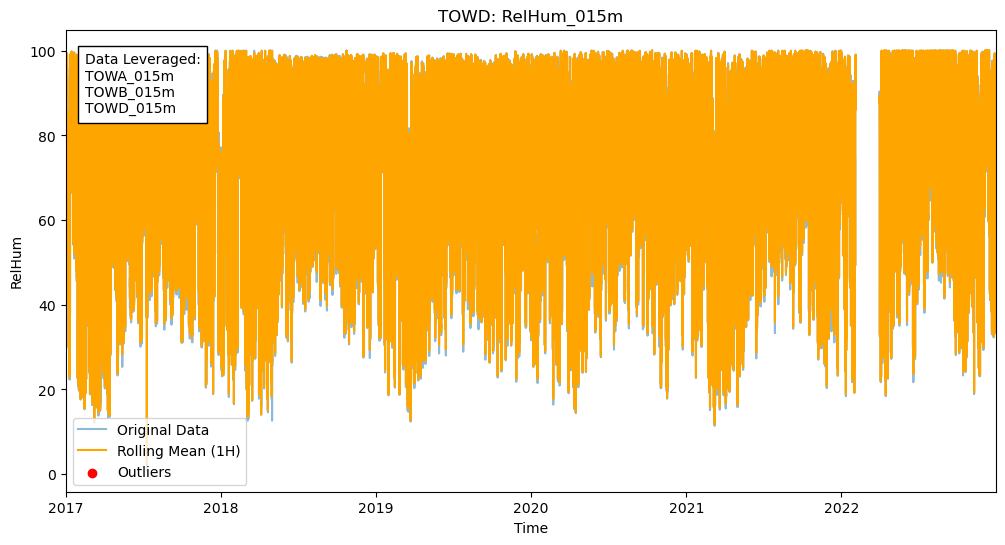

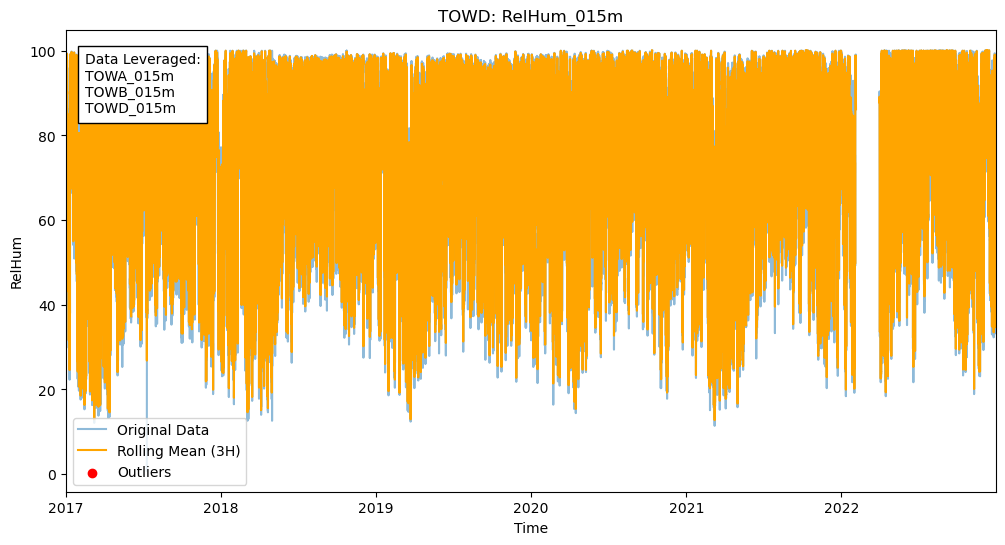

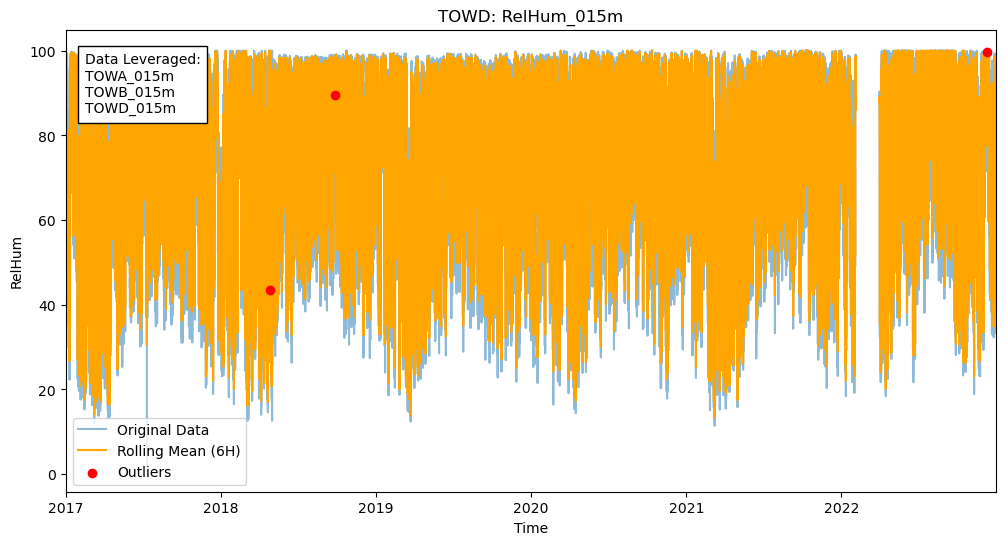

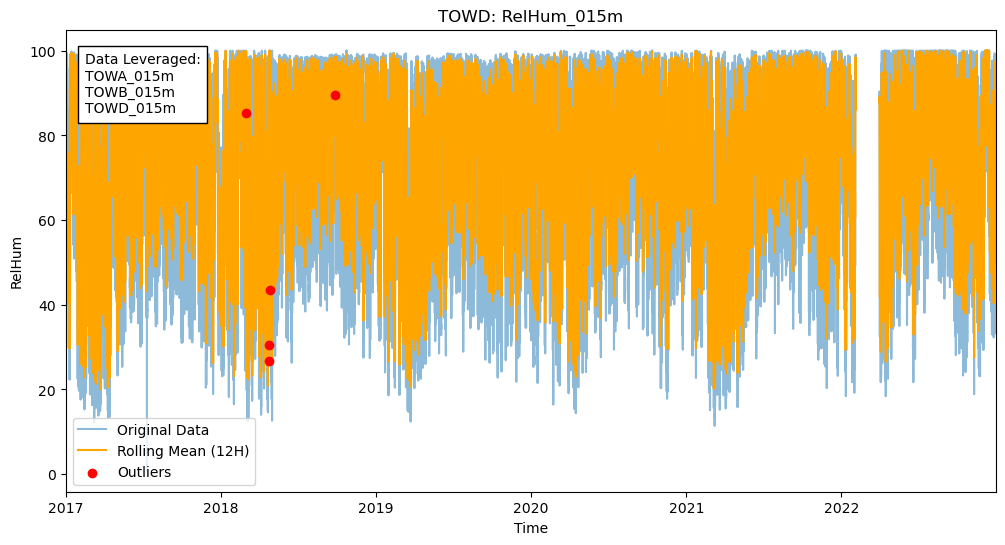

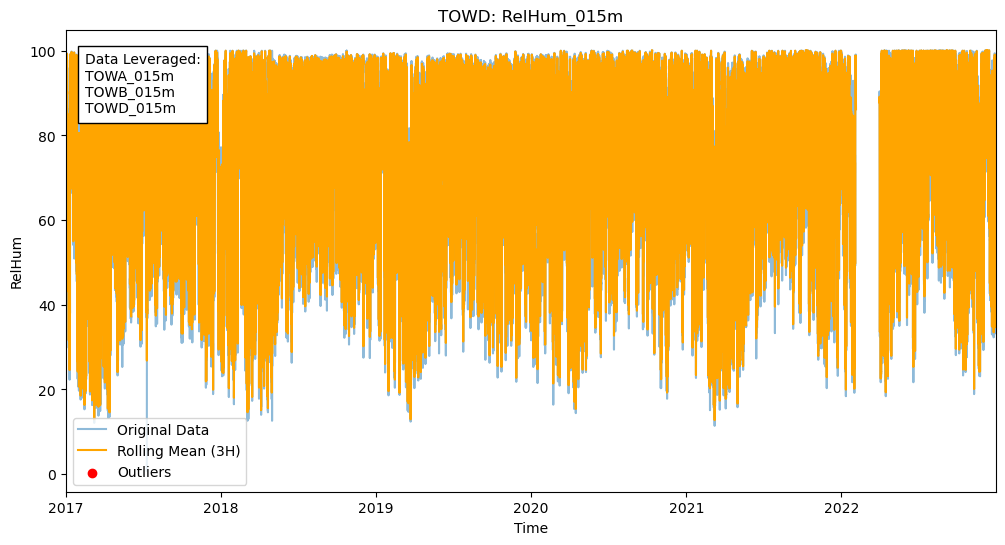

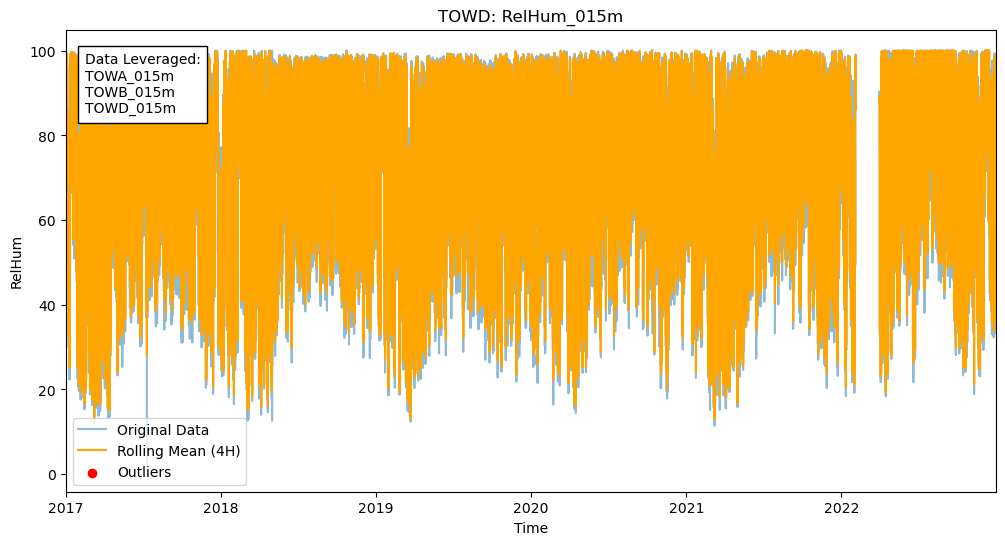

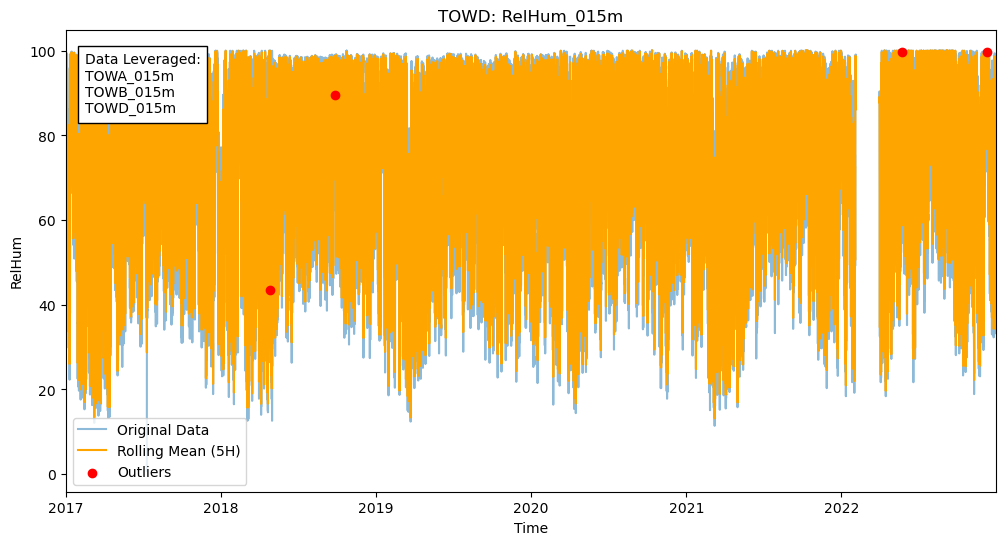

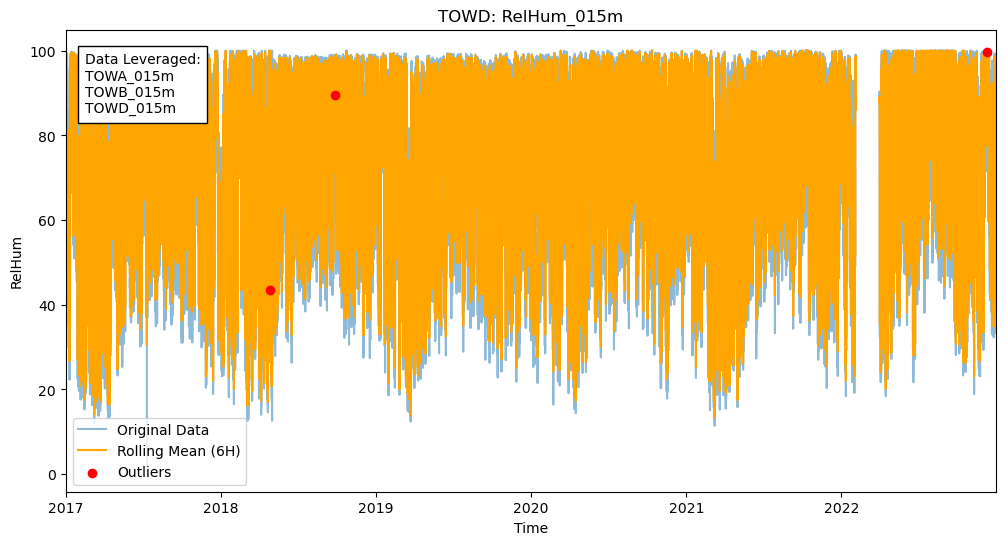

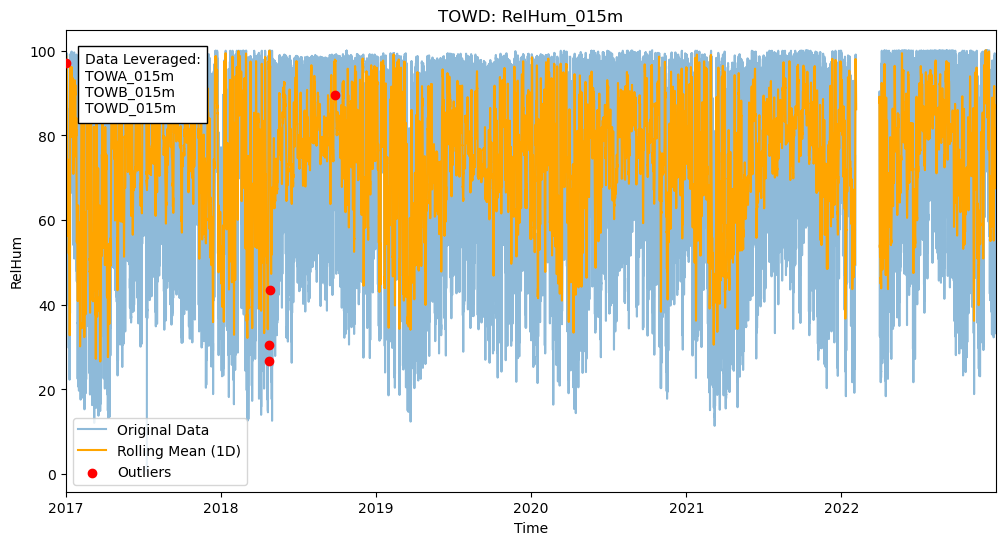

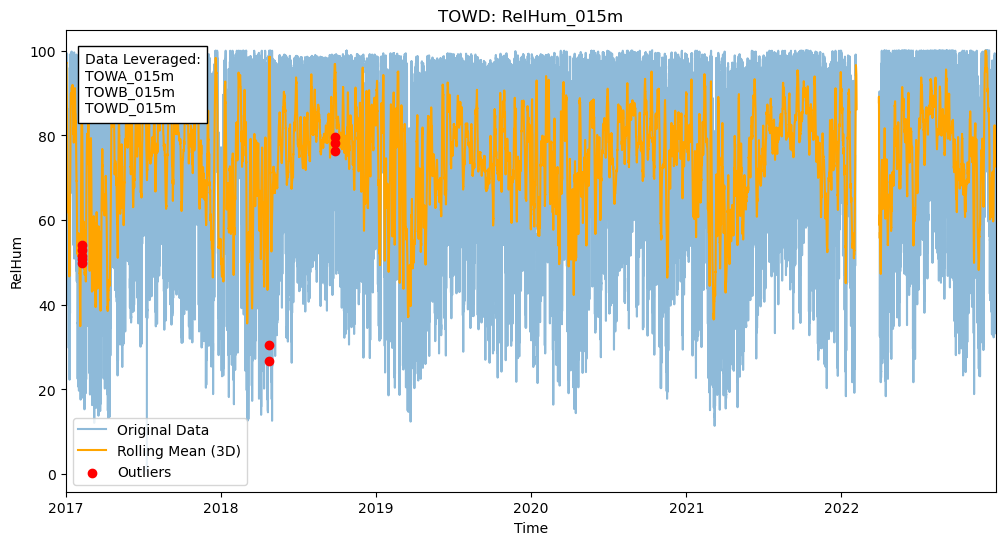

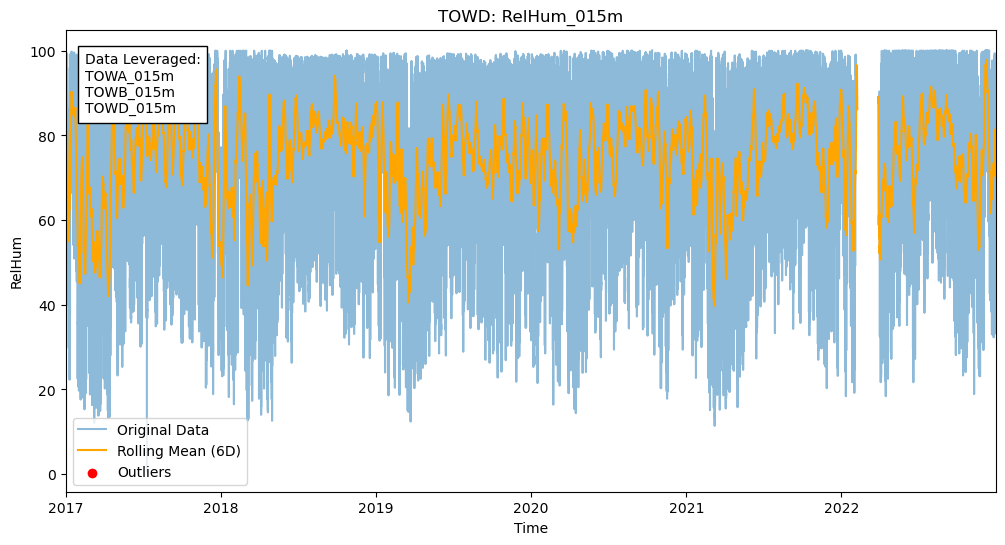

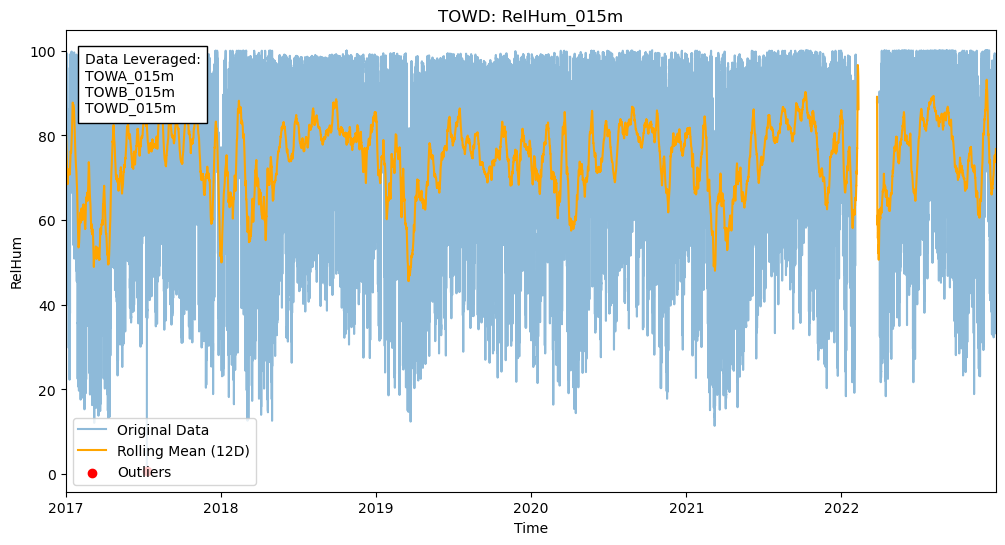

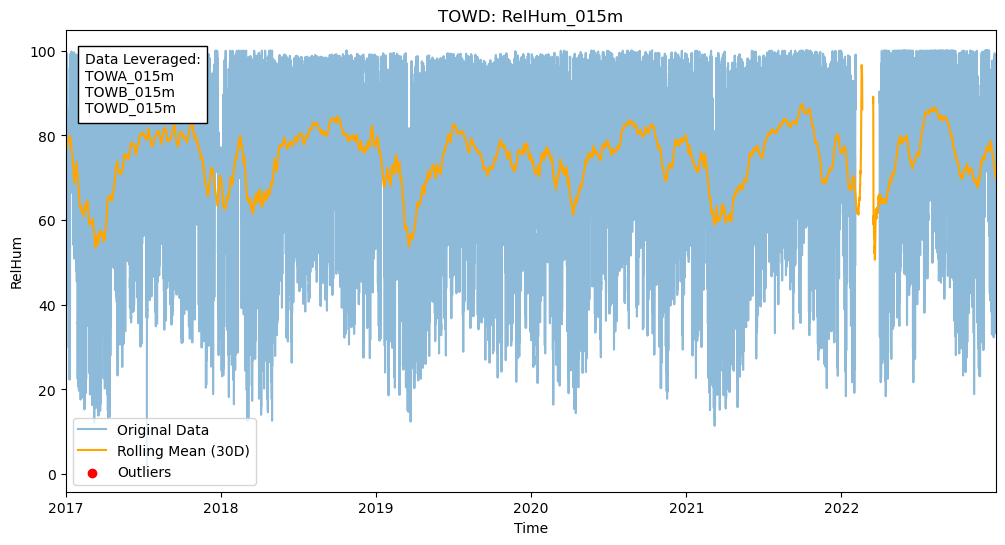

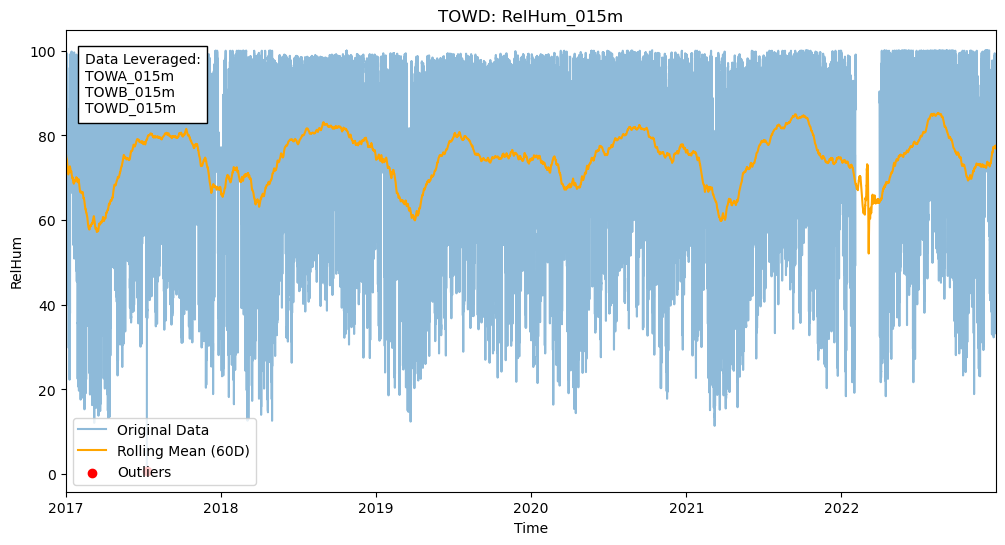

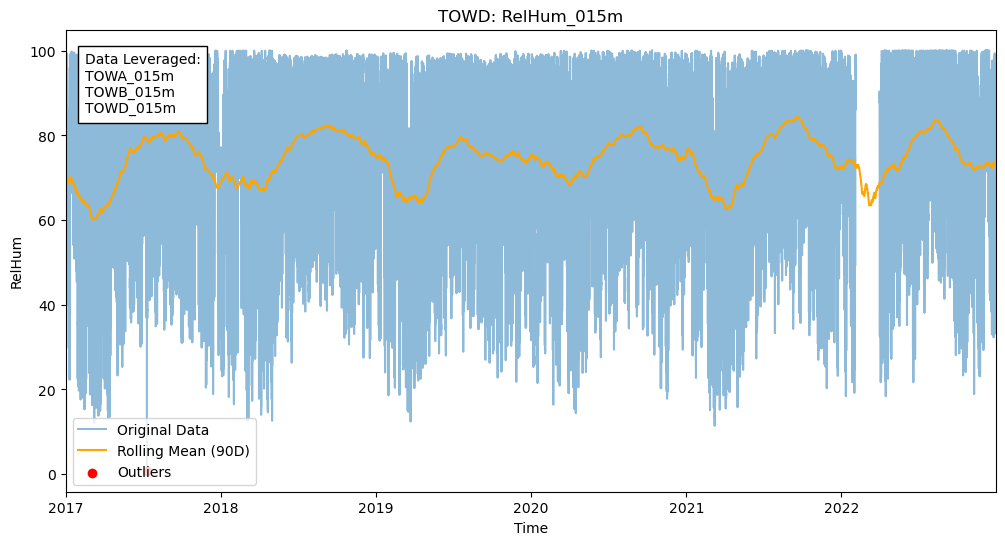

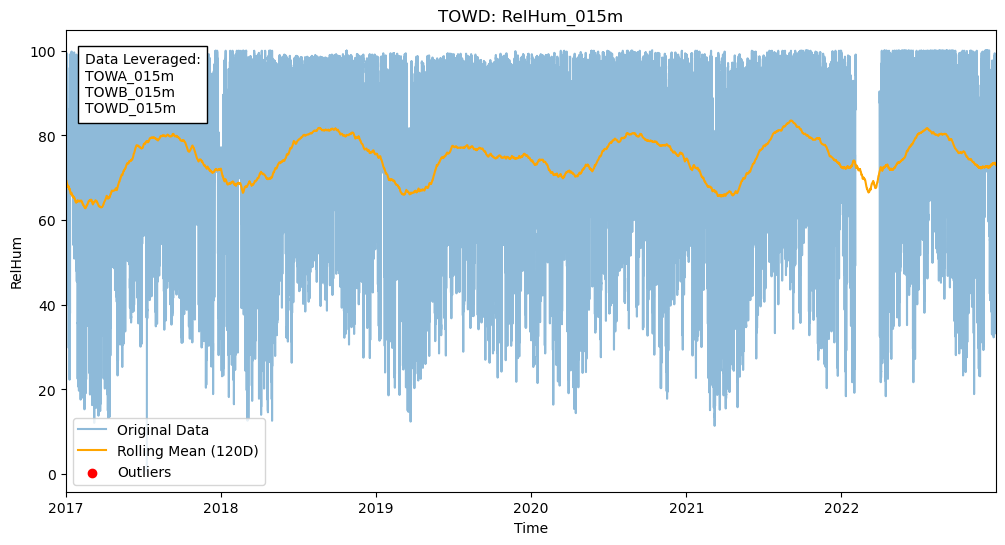

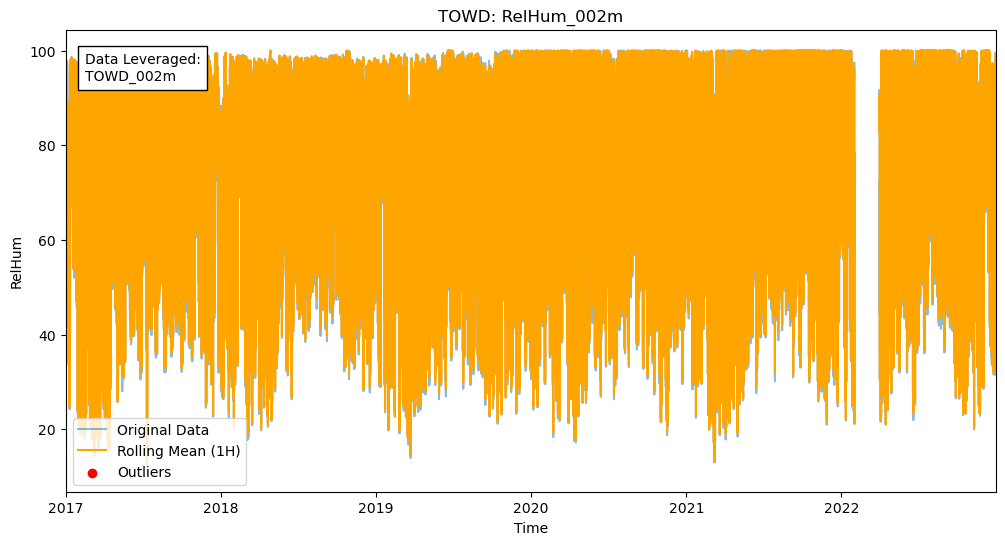

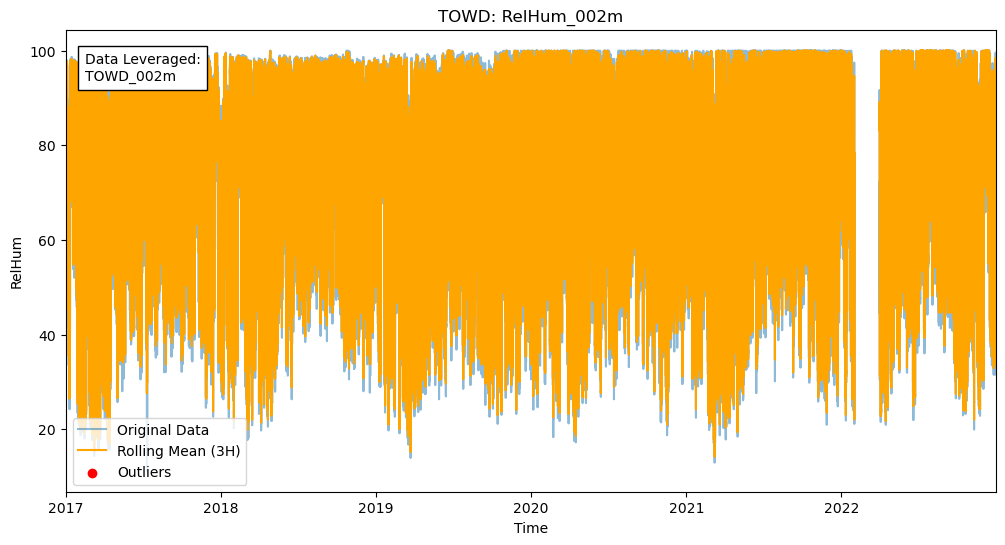

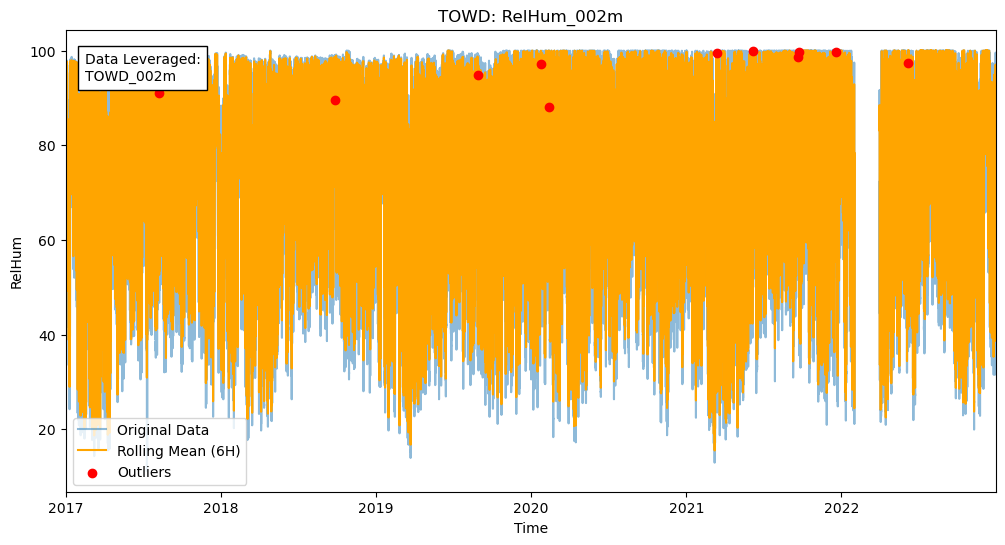

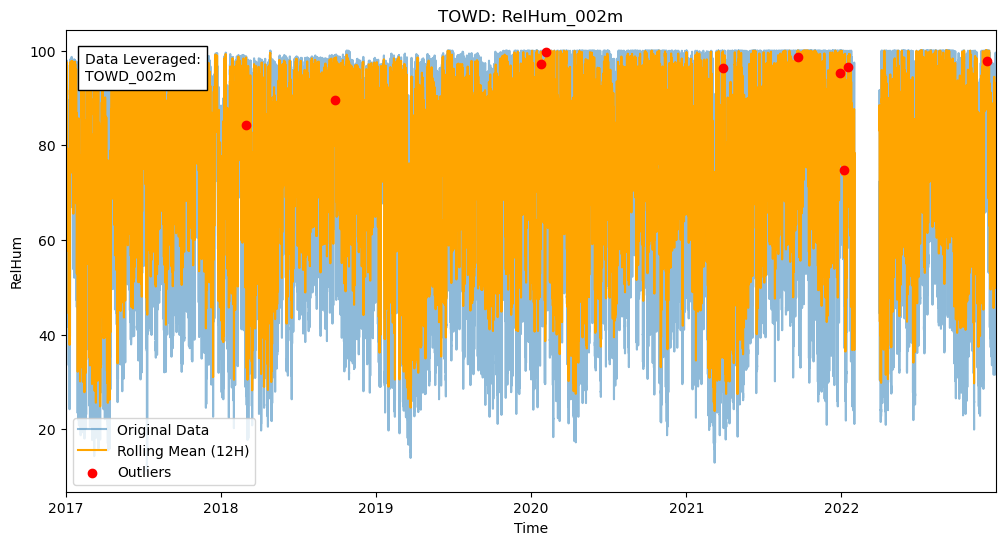

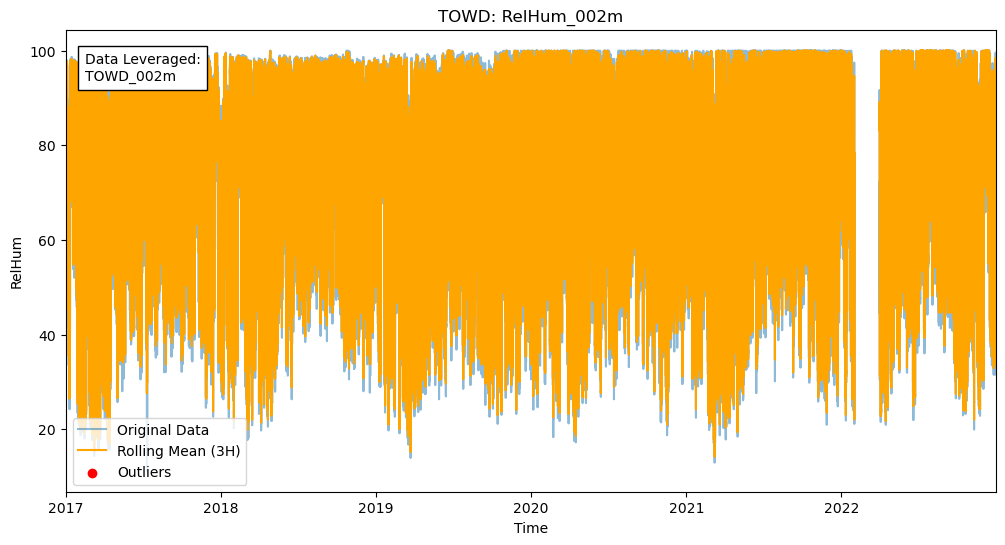

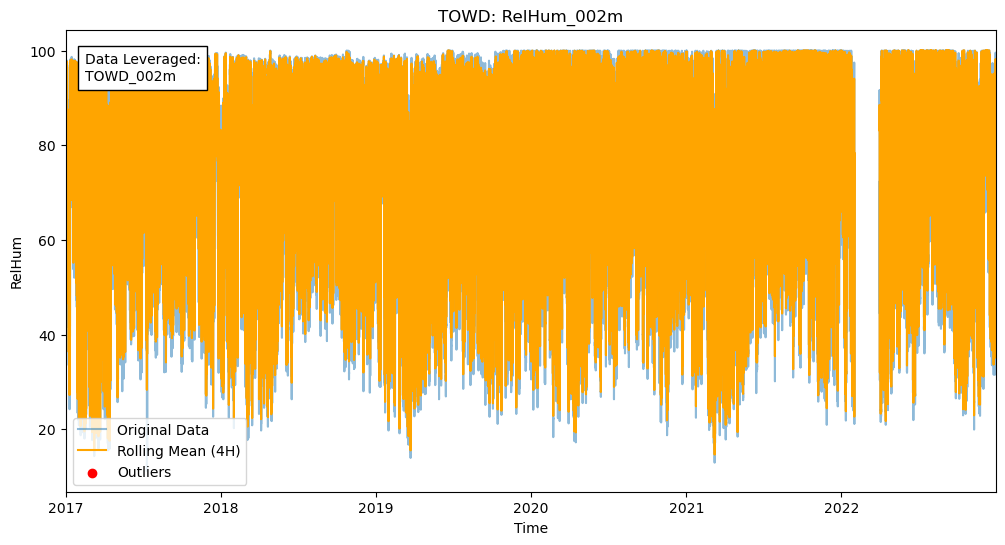

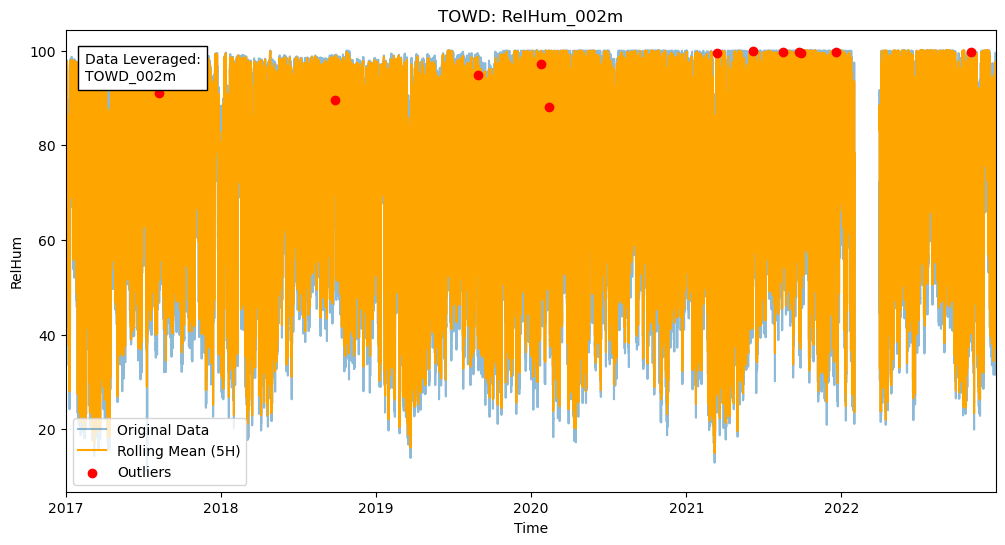

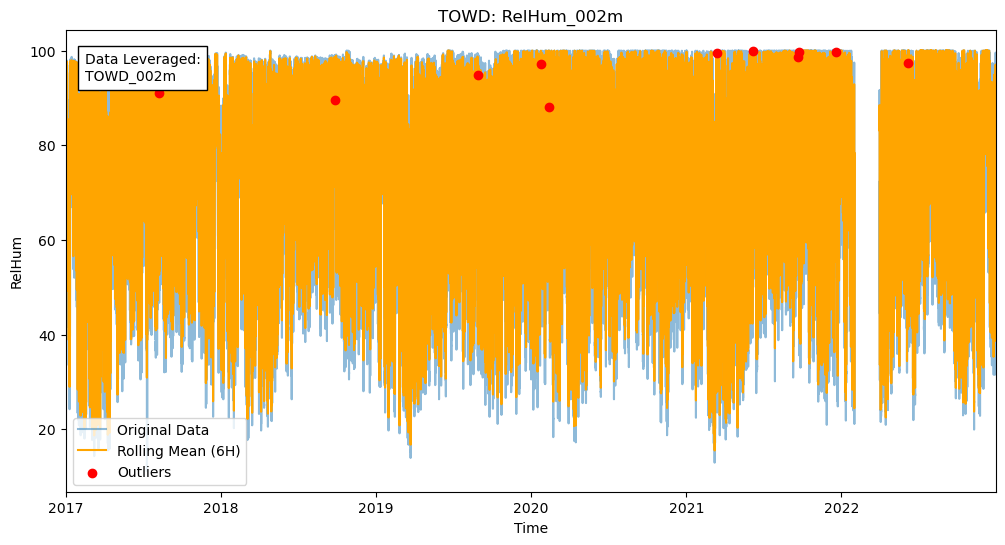

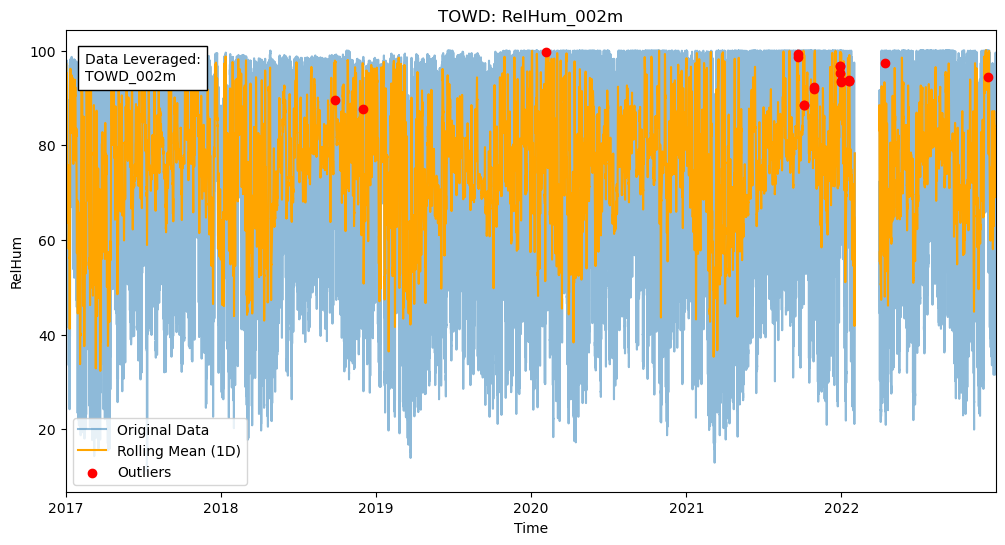

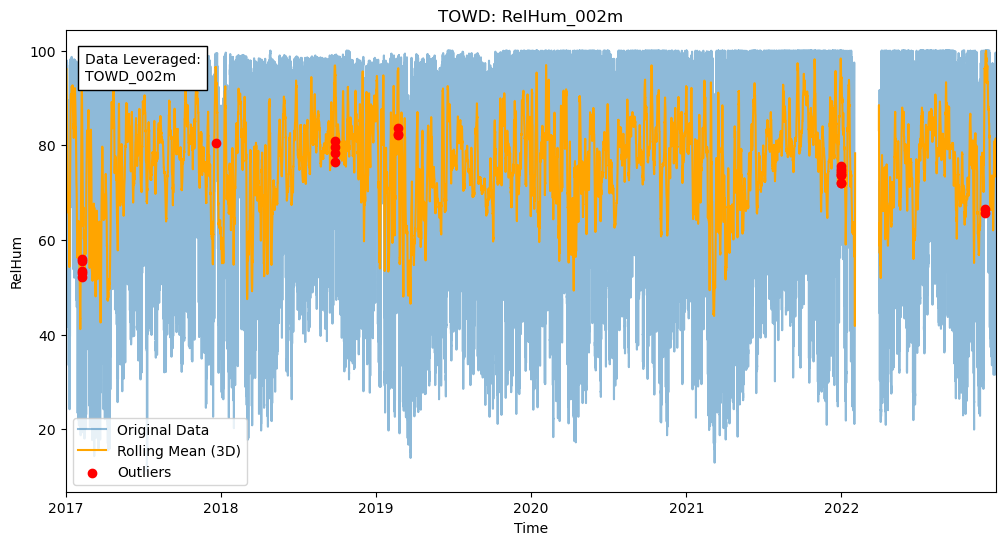

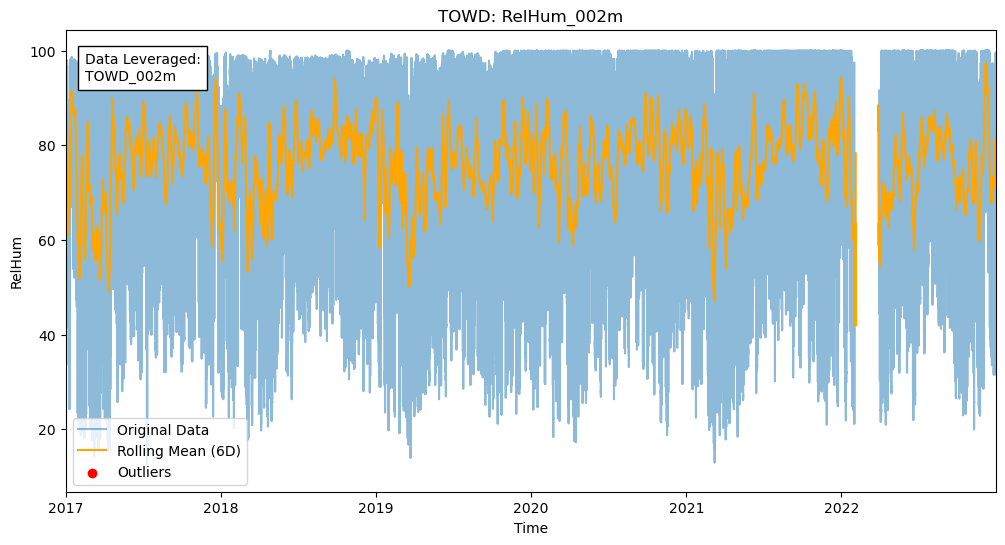

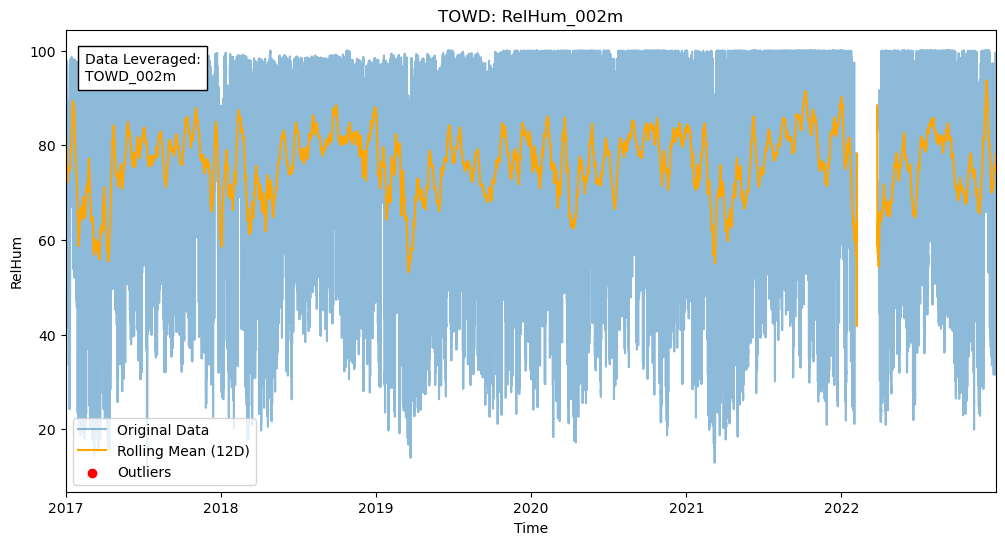

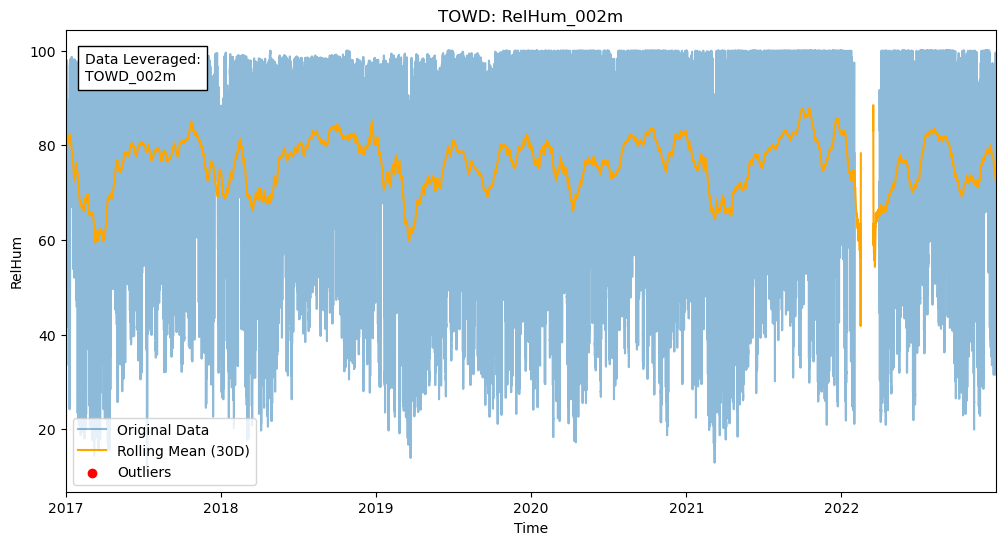

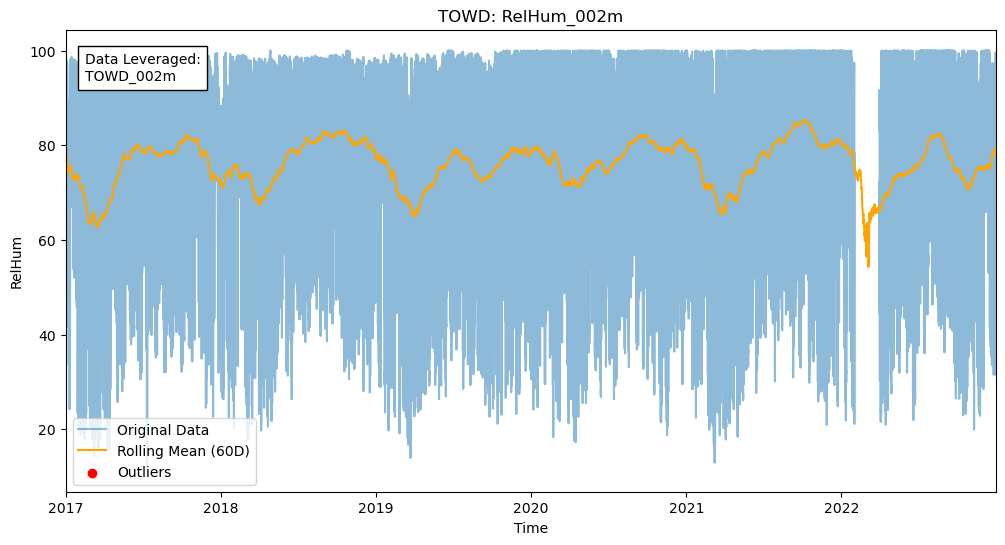

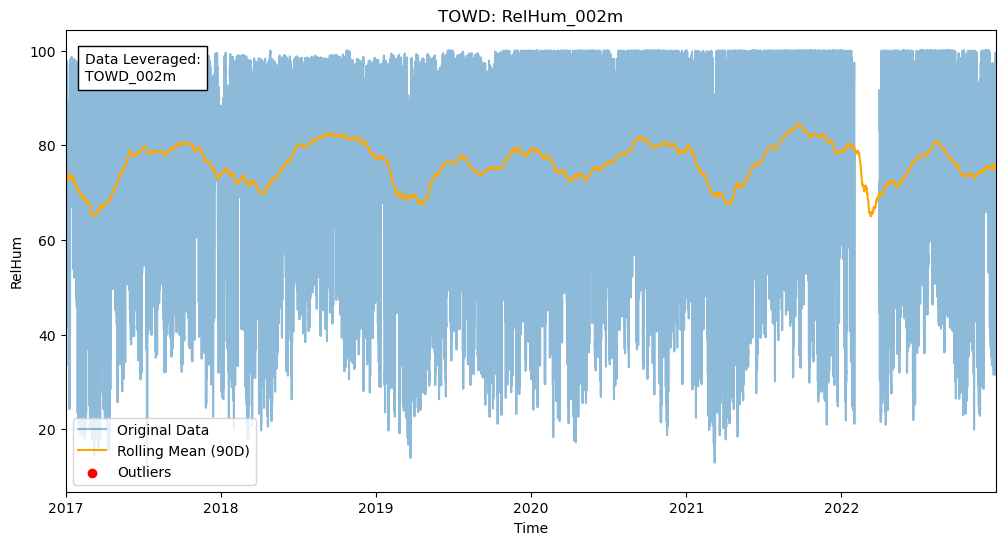

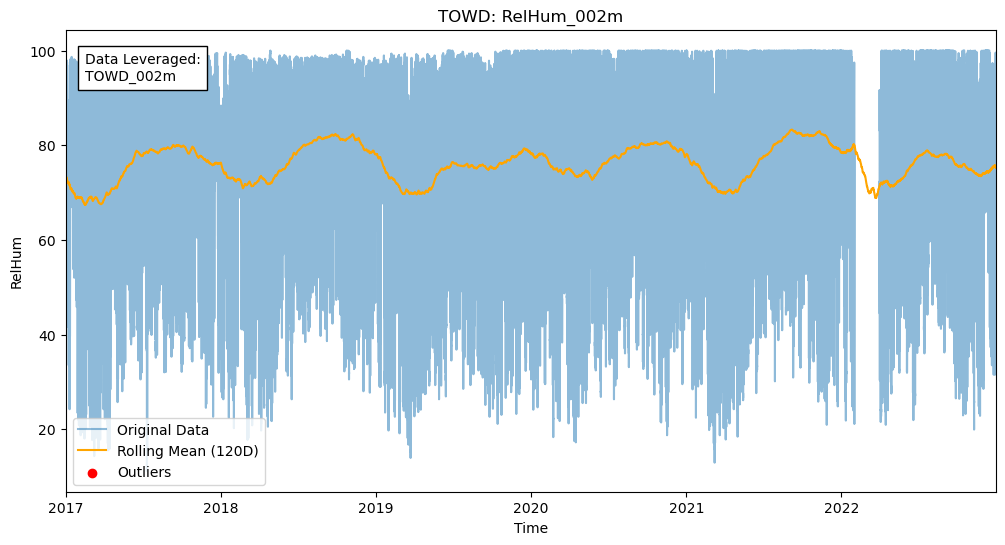

In [41]:
towers_data = tower_dfs_15m_8
tower_names = towers_of_interest
var = 'RelHum'
tower = 'TOWD'
z_threshold = 4
window_sizes = ['1H', '3H', '6H', '12H',
                '3H', '4H', '5H', '6H',
                '1D', '3D', '6D', '12D',
                '30D', '60D', '90D', '120D']

multi_tower_outliers = plot_variable_data_for_window_sizes(towers_data, tower_names, var, tower, window_sizes, z_threshold)

In [42]:
def get_random_sample(datetimes, proportion):
    sample_size = int(len(datetimes) * proportion)
    return random.sample(datetimes, sample_size)

def sample_dict(dict, proportion=0.2, selected_key=None):
        
    key = selected_key
    if selected_key:

        dict = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in dict[key]]
        
        dict_sample = get_random_sample(dict, proportion)
        
        print(f"Key: {key}")
        print(f"Sampled outliers in dict: {sorted(dict_sample)}")
        print(f"Number of outliers in dict: {len(sorted(dict))}")
        print(f"All outliers in dict: {sorted(dict)}")
    else:
        print(f"Key: {key} is not present in dict")

# Compare the dictionaries with a sample size of 5 and an optional selected key

sample_dict(multi_tower_outliers['015m'], 0.2, '3D')

Key: 3D
Sampled outliers in dict: ['2017-02-07 12:45:00', '2017-02-07 13:00:00']
Number of outliers in dict: 10
All outliers in dict: ['2017-02-07 12:00:00', '2017-02-07 12:15:00', '2017-02-07 12:30:00', '2017-02-07 12:45:00', '2017-02-07 13:00:00', '2018-04-24 08:00:00', '2018-04-24 08:45:00', '2018-09-25 15:30:00', '2018-09-25 15:45:00', '2018-09-25 16:00:00']


In [43]:
def calculate_cartesian_coordinates(wind_speed, wind_dir_deg):
    wind_dir_rad = np.deg2rad(wind_dir_deg)
    U = (-wind_speed * np.sin(wind_dir_rad)).astype(np.float32)  # Negative sign to align with meteorological convention
    V = (-wind_speed * np.cos(wind_dir_rad)).astype(np.float32)  # Negative sign to align with meteorological convention
    return U, V

def plot_wind_data(towers_data, tower_names, tower, eps=0.95, min_samples=2):
    
    combined_data = extract_variable_data_by_height(towers_data, tower_names)
    outlier_datetimes_by_height = []
    
    for height in set(col.split('_')[1] for col in towers_data[tower_names.index(tower)].columns):

        # Loop thru heights (e.g., 15m and 30m)
        outlier_counts = defaultdict(lambda: defaultdict(list))  # Dictionary to collect outliers by datetime and tower group

        # Determine the group based on tower name
        if tower in ['TOWA', 'TOWB', 'TOWD']:
            group = 'group1'
        elif tower in ['TOWF', 'TOWS']:
            group = 'group2'
        elif tower == 'TOWY':
            group = 'group3'
        else:
            group = 'others'
        
        key_wind = ('WSpdMph', height, group)
        key_dir = ('WDir', height, group)
        
        if key_wind in combined_data and key_dir in combined_data:
            
            data_wind = combined_data[key_wind]
            data_dir = combined_data[key_dir]
            
            col = f'{tower}_{height}'
            
            if col in data_wind.columns and col in data_dir.columns:

                for towerheight in data_wind.columns:
                
                    wind_speed_data = data_wind[towerheight]
                    wind_dir_data = data_dir[towerheight]

                    # Calculate Cartesian coordinates
                    U, V = calculate_cartesian_coordinates(wind_speed_data, wind_dir_data)
                
                    # Remove rows with NaN values
                    nan_indices = np.isnan(U) | np.isnan(V)
                    U_clean = U[~nan_indices]
                    V_clean = V[~nan_indices]
                    if towerheight == col:
                        Udata = U_clean
                        Vdata = V_clean

                    # Perform DBSCAN clustering
                    print(f'Clustering {towerheight}')
                    X = np.column_stack((U_clean, V_clean))
                    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
                
                    # Detect outliers
                    outlier_indices = clustering.labels_ == -1  # mask, -1 indicates outlier points (True)
                    outlier_dates = data_wind.index[~nan_indices][outlier_indices].tolist()
                    for date in outlier_dates:
                        outlier_counts[date][group].append(towerheight)
                
                # Identify points where multiple towers in the same group have outliers at the same datetime
                outlier_datetimes = []
                for date, towerheight in outlier_counts.items():
                    if col in towerheight[group]:
                        if len(towerheight[group]) == 1:
                            outlier_datetimes.append(date)
                print(f'Number of outliers: {len(outlier_datetimes)}')

                # Plot Cartesian coordinates with outliers and normal points
                fig = go.Figure()

                # Add normal points
                fig.add_trace(go.Scatter(
                    x=Udata, 
                    y=Vdata,
                    mode='markers',
                    marker=dict(color='blue', size=10, opacity=0.5),
                    hoverinfo='skip',
                    name='Normal Points'
                ))
                
                # Add outliers
                fig.add_trace(go.Scatter(
                    x=Udata.loc[Udata.index.isin(outlier_datetimes)], 
                    y=Vdata.loc[Vdata.index.isin(outlier_datetimes)],
                    mode='markers',
                    marker=dict(color='red', size=10),
                    customdata=outlier_datetimes,
                    hovertemplate='Outlier Datetime: %{customdata}<br>U: %{x}<br>V: %{y}<extra></extra>',
                    name='Outliers'
                ))
                
                # Update layout
                fig.update_layout(
                    title=f'{tower}: Wind Speed Components at Height {height}',
                    xaxis_title='U (Eastward Wind Component)',
                    yaxis_title='V (Northward Wind Component)',
                    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                    template='plotly_white'
                )

                plt.show(fig)

---
# Outlier detection

### 1(a). Simple rolling window variables
TempC, RelHum, AbsHum, RelHum, WSpdMph, PkWSpdMph, SolarRadWm2, BarPresMb

The window sizes were determined by rigorous testing; not every variable should be treated the same
1. Visually determine how many outliers I expect and when I expect most outliers to be found for a variable (testing on Tower A)
2. Calculate the accuracy of a single-tower approach or a multi-tower leveraging approach; this number does not consider false negatives (I did not have time to manually count every single outlier); the multi-tower approach outperformed the single-tower approach every time
3. Test 1, 3, 6, 12 hours; 1, 3, 6, 12 days; and 30, 60, 90, 120 days for the window size; test 3 standard devs and 4 standard devs as the outlier threshold
4. Determine which variables are best suited for a rolling window approach (TempC, RelHum, AbsHum, RelHum, WSpdMph, PkWSpdMph, SolarRadWm2, BarPresMb)
5. Determine which variables are best suited for manual outlier removal (Sigma, SigPhi, VSSpdMph)
6. Determine which variables need a unique approach (WDir)

In [44]:
# Rolling window outlier detection function for non-circular data
def rolling_window_outlier_detection(data, window_size, z_threshold):
    rolling_means = data.rolling(window=window_size, center=True).mean()
    rolling_stds = data.rolling(window=window_size, center=True).std()
    
    overall_mean = rolling_means.mean(axis=1)
    overall_std = rolling_stds.mean(axis=1)
    
    outliers = pd.DataFrame(index=data.index, columns=data.columns, dtype=bool)
    
    for column in data.columns:
        individual_zscores = (data[column] - rolling_means[column]) / rolling_stds[column]
        combined_zscores = (data[column] - overall_mean) / overall_std
        
        individual_outliers = np.abs(individual_zscores) > z_threshold
        combined_outliers = np.abs(combined_zscores) > z_threshold
        
        confirmed_outliers = individual_outliers & combined_outliers
        outliers[column] = confirmed_outliers

    return outliers, rolling_means

In [45]:
# Updated extract variable data by height function
def extract_variable_data_by_height(towers_data, tower_names):
    combined_data = {}
    
    # Define tower groups
    group1 = ['TOWA', 'TOWB', 'TOWD']
    group2 = ['TOWF', 'TOWS']
    group3 = ['TOWY']
    
    # Helper function to determine group
    def get_group(tower_name):
        if tower_name in group1:
            return 'group1'
        elif tower_name in group2:
            return 'group2'
        elif tower_name in group3:
            return 'group3'
        else:
            return 'others'

    # Combine data by height and group
    for i, (tower_df, tower_name) in enumerate(zip(towers_data, tower_names)):
        for column in tower_df.columns:
            variable_type, height = column.split('_')
            group = get_group(tower_name)
            combined_key = (variable_type, height, group)
            col_name = f"{tower_name}_{height}"
            
            if combined_key not in combined_data:
                combined_data[combined_key] = []
            combined_data[combined_key].append(tower_df[column].rename(col_name))
    
    # Concatenate data for each combined key
    for key in combined_data.keys():
        combined_data[key] = pd.concat(combined_data[key], axis=1)
    
    return combined_data

In [46]:
# Function to plot variable data for window sizes with outlier detection
import collections
def plot_variable_data_for_window_sizes(towers_data, tower_names, var, tower):
    
    combined_data = extract_variable_data_by_height(towers_data, tower_names)
    all_outliers = collections.defaultdict(dict)
    
    for height in set(col.split('_')[1] for col in towers_data[tower_names.index(tower)].columns if col.startswith(var)):
        
        column = f"{tower}_{height}"
        # print(tower, var, height)
        
        # Choose the appropriate key for the specified tower
        group = 'others'
        if tower in ['TOWA', 'TOWB', 'TOWD']:
            group = 'group1'
        elif tower in ['TOWF', 'TOWS']:
            group = 'group2'
        elif tower == 'TOWY':
            group = 'group3'
        
        key = (var, height, group)
        if key not in combined_data:
            continue
        
        data = combined_data[key]
        if column not in data.columns:
            continue

        # Set parameters for each variable
        if var == 'TempC':
            window_size = '3H'
            z_threshold = 3

        elif var == 'AbsHum':
            window_size = '3H'
            z_threshold = 3

        elif var == 'RelHum':
            window_size = '12H'
            z_threshold = 4

        elif var == 'WSpdMph':
            window_size = '3H'
            z_threshold = 3

        elif var == 'PkWSpdMph':
            window_size = '6H'
            z_threshold = 4

        elif var == 'BarPresMb':
            window_size = '3H'
            z_threshold = 3

        elif var == 'SolarRadWm2':
            window_size = '12H'
            z_threshold = 4
            
        else:
            continue

        # print(f'Finding outliers for {var} using a window size of {window_size} and z-threshold of {z_threshold}.')
        outliers, rolling_means = rolling_window_outlier_detection(data, window_size, z_threshold)
        outlier_points = data[column][outliers[column]]
        all_outliers[height] = [outlier_points.index, data[column]]
        
    return all_outliers

In [47]:
towers_data = tower_dfs_15m_8
tower_names = towers_of_interest

window_vars = ['TempC', 'RelHum', 'AbsHum', 'WSpdMph', 'PkWSpdMph', 'SolarRadWm2', 'BarPresMb']
towers = ['TOWA', 'TOWB', 'TOWD', 'TOWF', 'TOWS', 'TOWY']

all_outliers = {}
for var in window_vars:
    all_outliers[var] = {}
    for tower in towers:
        multi_tower_outliers = plot_variable_data_for_window_sizes(towers_data, tower_names, var, tower)
        all_outliers[var][tower] = multi_tower_outliers

### 1(b). Simple non-rolling window variables
Sigma, SigPhi

In [48]:
def set_to_nan(data, names, var, tower):
    combined_data = extract_variable_data_by_height(towers_data, tower_names)
    all_outliers = collections.defaultdict(dict)
    for height in set(col.split('_')[1] for col in towers_data[tower_names.index(tower)].columns if col.startswith(var)):
        column = f"{tower}_{height}"
            
        group = 'others'
        if tower in ['TOWA', 'TOWB', 'TOWD']:
            group = 'group1'
        elif tower in ['TOWF', 'TOWS']:
            group = 'group2'
        elif tower == 'TOWY':
            group = 'group3'
        
        key = (var, height, group)
        if key not in combined_data:
            continue
        
        data = combined_data[key]
        if column not in data.columns:
            continue

        zero_indices = data[data[column] == 0].index
        data = data.replace(0, np.NaN)
        all_outliers[height] = [zero_indices, data[column]]

    return all_outliers

In [49]:
# set 0 to NaN
zero_vars = ['Sigma', 'SigPhi']
towers = ['TOWA', 'TOWB', 'TOWD', 'TOWF', 'TOWS', 'TOWY']
for var in zero_vars:
    all_outliers[var] = {}
    for tower in towers:
        multi_tower_zeros = set_to_nan(towers_data, tower_names, var, tower)
        all_outliers[var][tower] = multi_tower_zeros

### 1(c) Wind direction clustering
WDir, WSpdMph

In [50]:
def calculate_cartesian_coordinates(wind_speed, wind_dir_deg):
    wind_dir_rad = np.deg2rad(wind_dir_deg)
    U = (-wind_speed * np.sin(wind_dir_rad)).astype(np.float32)  # Negative sign to align with meteorological convention
    V = (-wind_speed * np.cos(wind_dir_rad)).astype(np.float32)  # Negative sign to align with meteorological convention
    return U, V

def plot_wind_data(towers_data, data_dict, var='WSpdMph', eps=0.95, min_samples=2, tower_groups=None):
    if tower_groups is None:
        tower_groups = {
            'group1': ['TOWA', 'TOWB', 'TOWD'],
            'group2': ['TOWF', 'TOWS'],
            'group3': ['TOWY']
        }

    true_wdir_outliers = defaultdict(list)

    for tower, heights in data_dict[var].items():

        # Determine the group based on tower name
        group = 'others'
        for g, towers_in_group in tower_groups.items():
            if tower in towers_in_group:
                group = g
                break

        print(f'Working on tower {tower} in {group}')

        for height, (datetime_indices_wspd, wspd_series) in heights.items():

            # Initialize the outlier list for this tower-height combination
            true_wdir_outliers[(tower, height)] = []

            wspd_column = f'{var}_{height}'

            tower_df = None
            for df in towers_data:
                if wspd_column in df.columns:
                    tower_df = df
                    break
            
            if tower_df is not None and var in data_dict and tower in data_dict[var] and height in data_dict[var][tower]:

                wdir_column = f'WDir_{height}'
                
                wspd_data = data_dict[var][tower][height][1]
                wdir_data = tower_df[wdir_column]

                # Calculate Cartesian coordinates
                U, V = calculate_cartesian_coordinates(wspd_data, wdir_data)
                
                # Remove rows with NaN values
                nan_indices = np.isnan(U) | np.isnan(V)
                U_clean = U[~nan_indices]
                V_clean = V[~nan_indices]
                
                # Perform DBSCAN clustering
                X = np.column_stack((U_clean, V_clean))
                clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
                
                # Detect outliers
                outlier_indices = clustering.labels_ == -1  # mask, -1 indicates outlier points (True)
                wdir_data_nonnan = wdir_data[~nan_indices]
                outlier_dates = wdir_data_nonnan.index[outlier_indices]

                # Collect outliers in a list
                outliers_to_add = []
                for outlier_date in outlier_dates:
                    if outlier_date not in datetime_indices_wspd:
                        outliers_to_add.append(outlier_date)

                # Append all outliers in one go
                true_wdir_outliers[(tower, height)].extend(outliers_to_add)
                del wspd_data, wdir_data, U, V, U_clean, V_clean, X, clustering, outlier_indices, wdir_data_nonnan, outlier_dates, outliers_to_add

    # Check for outliers detected at the same height in different towers of the same group
    group_outliers = defaultdict(list)
    for (tower, height), outliers in true_wdir_outliers.items():
        for group_name, towers_in_group in tower_groups.items():
            if tower in towers_in_group:
                for other_tower in towers_in_group:
                    if other_tower != tower and (other_tower, height) in true_wdir_outliers:
                        common_outliers = set(outliers) & set(true_wdir_outliers[(other_tower, height)])
                        for outlier_date in common_outliers:
                            group_outliers[(tower, height)].append(outlier_date)
                            group_outliers[(other_tower, height)].append(outlier_date)

    # Remove common outliers from true_wdir_outliers
    for (tower, height), outliers in group_outliers.items():
        true_wdir_outliers[(tower, height)] = [date for date in true_wdir_outliers[(tower, height)] if date not in outliers]

    # print(true_wdir_outliers)
    return true_wdir_outliers

In [51]:
true_wdir_outliers = plot_wind_data(tower_dfs_15m_8, all_outliers)

Working on tower TOWA in group1
Working on tower TOWB in group1
Working on tower TOWD in group1
Working on tower TOWF in group2
Working on tower TOWS in group2
Working on tower TOWY in group3


In [52]:
for key in true_wdir_outliers:
    true_wdir_outliers[key] = pd.DatetimeIndex(true_wdir_outliers[key])

### 2. Prep for export

#### Wind Direction

In [53]:
all_outliers['WDir'] = {}
for (tower, height), datetimeindex in true_wdir_outliers.items():
    all_outliers['WDir'][tower] = {}
    tower_idx = tower_names.index(tower)
    df = tower_dfs_15m_8[tower_idx]
    column_name = f'WDir_{height}'
    
    if column_name in df.columns:
        wdir_series = df[column_name]
        # Store the pandas Series in the appropriate place
        all_outliers['WDir'][tower][height] = [datetimeindex, wdir_series]

#### VSSpdMph and PrecipIn

In [54]:
# List of variables to process
vars_to_process = ['VSSpdMph', 'PrecipIn']

# Add variables to all_outliers
for var in vars_to_process:
    all_outliers[var] = {}
    for tower, df in zip(tower_names, tower_dfs_15m_8):
        all_outliers[var][tower] = {}
        for column_name in df.columns:
            if var in column_name:
                height = column_name.split('_')[-1]  # Extract height from column name
                var_series = df[column_name]
                
                # Store the pandas Series in the appropriate place
                all_outliers[var][tower][height] = [None, var_series]

In [55]:
cleaned_data = {}
vars = ['TempC',
        'RelHum', 'AbsHum', 
        'WSpdMph', 'PkWSpdMph', 'VSSpdMph',
        'SolarRadWm2', 
        'BarPresMb',
        'Sigma', 'SigPhi',
        'WDir',
        'PrecipIn']

for var in vars:
    cleaned_data[var] = {}
    for tower in towers:
        cleaned_data[var][tower] = {}
        heights = list(all_outliers[var][tower].keys())
        for height in heights:
            outliers = all_outliers[var][tower][height][0]
            data = all_outliers[var][tower][height][1]
            data.loc[outliers] = np.nan
            cleaned_data[var][tower][height] = data

In [79]:
# Resulting list of dataframes
tower_dfs_15m_9 = []
toi = []

# Extract towers
towers = set()
for var in cleaned_data:
    towers.update(cleaned_data[var].keys())

# Iterate over each tower
for tower in towers:
    combined_data = {}
    for var in cleaned_data:
        if tower in cleaned_data[var]:
            for height in cleaned_data[var][tower]:
                column_name = f"{var}_{height}"
                series = cleaned_data[var][tower][height]
                combined_data[column_name] = series
    
    # Convert the dictionary to a DataFrame
    combined_df = pd.DataFrame(combined_data)
    tower_dfs_15m_9.append((tower, combined_df))

tower_dfs_15m_9 = sorted(tower_dfs_15m_9, key=lambda x: x[0])
tower_dfs_15m_9 = [x[1] for x in tower_dfs_15m_9]

### 3. Export files and perform manual checks
The rolling window approach was fairly accurate but missed a LOT of outliers; so I had to take a manual approach to remove outliers afterward
1. Using a dashboard, I interactively visualized the data over time as line graphs
2. Working through each Tower's VariableNameUnit_Height{m}, I visually identified outliers by comparing one line to all the others
3. When clicking on a point, the datetime is outputted on the screen in a way that I could copy and paste it into a csv.
4. The csv contained a start_datetime and end_datetime column, which I populated with the copied and pasted dates (if only one point was an outlier, I only populated the start_datetime; if the outlier was consecutive over time, I provided the start and end datetime of the consecutive outliers)
5. Outliers could be large jumps in the data (those that don't correspond with jumps occuring at the same time as other towers; those are likely real jumps), brief periods of identical values, or visual strangeness (magnitude smaller or larger variations, stair-stepping, etc.)

In [83]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal', random_state=0)

# normalize 0-heavy data
for df in tower_dfs_15m_9:
    cols = df.columns
    for col in cols:
        if col.startswith('PrecipIn'):
            print(df[col].min())
            var, height = col.split('_')[0], col.split('_')[1]
            new_col = f'{var}Log_{height}'
            df[col] = qt.fit_transform(df[[col]])
            # df[col] = df[col].apply(lambda x: np.log(x + 0.01))
            print(df[col])

-4.605170185988091
datetime
2017-01-01 00:00:00    1.926403
2017-01-01 00:15:00    1.858747
2017-01-01 00:30:00    1.858747
2017-01-01 00:45:00    1.756055
2017-01-01 01:00:00    1.756055
                         ...   
2022-12-31 23:00:00   -5.199338
2022-12-31 23:15:00   -5.199338
2022-12-31 23:30:00   -5.199338
2022-12-31 23:45:00   -5.199338
NaT                         NaN
Name: PrecipIn_015m, Length: 210337, dtype: float64
-4.605170185988091
datetime
2017-01-01 00:00:00         NaN
2017-01-01 00:15:00         NaN
2017-01-01 00:30:00         NaN
2017-01-01 00:45:00         NaN
2017-01-01 01:00:00         NaN
                         ...   
2022-12-31 23:00:00   -5.199338
2022-12-31 23:15:00   -5.199338
2022-12-31 23:30:00   -5.199338
2022-12-31 23:45:00   -5.199338
NaT                         NaN
Name: PrecipIn_015m, Length: 210337, dtype: float64
-4.605170185988091
datetime
2017-01-01 00:00:00    2.023292
2017-01-01 00:15:00    1.792374
2017-01-01 00:30:00    1.792374
2017-01-01 0

In [84]:
tower_dfs_15m_9[0]['PrecipIn_015m']

datetime
2017-01-01 00:00:00    1.926403
2017-01-01 00:15:00    1.858747
2017-01-01 00:30:00    1.858747
2017-01-01 00:45:00    1.756055
2017-01-01 01:00:00    1.756055
                         ...   
2022-12-31 23:00:00   -5.199338
2022-12-31 23:15:00   -5.199338
2022-12-31 23:30:00   -5.199338
2022-12-31 23:45:00   -5.199338
NaT                         NaN
Name: PrecipIn_015m, Length: 210337, dtype: float64

In [85]:
for df, tower in zip(tower_dfs_15m_9, towers_of_interest):
    df.index.name = 'datetime'
    df.to_csv(f'../data/{tower}_2017-2022_qa-precheck.csv')

### 4. Remove manually identified outliers

In [49]:
# List to store the modified dataframes
tower_dfs_15m_clean = []

# Function to set values to NaN based on datetime ranges
def set_nan_in_dataframe(df, ranges):
    df2 = df.copy()
    for _, row in ranges.iterrows():
        start = row['datetime_start']
        finish = row['datetime_end'] if pd.notnull(row['datetime_end']) else row['datetime_start']
        column = row['column']
        if column in df2.columns:
            df2.loc[start:finish, column] = np.nan
    return df2

# Iterate through each tower of interest
for tower, tower_df_15m in zip(towers_of_interest, tower_dfs_15m_9):
    print(tower)
    
    # Construct the filename
    filename = f"../data/{tower}_2017-2022_manual-qa-outliers.csv"
    file_path = os.path.join(directory_path, filename)
    
    if os.path.exists(file_path):
        # Load the CSV into a dataframe
        tower_outliers = pd.read_csv(
            file_path,
            header=0,
            parse_dates=['datetime_start', 'datetime_end']
        )
        
        # Extract datetime ranges and corresponding columns
        ranges = tower_outliers[['datetime_start', 'datetime_end', 'column']]
        
        # Convert the "datetime_start" and "datetime_end" to datetime
        ranges['datetime_start'] = pd.to_datetime(ranges['datetime_start'], format='mixed')
        ranges['datetime_end'] = pd.to_datetime(ranges['datetime_end'], format='mixed')

        # Set the appropriate values to NaN
        tower_df_outliers_removed = set_nan_in_dataframe(tower_df_15m, ranges)
        
        # Append the modified dataframe to the list
        tower_dfs_15m_clean.append(tower_df_outliers_removed)

TOWA
TOWB
TOWD
TOWF
TOWS
TOWY


### 5. Export quality assessed data

In [1]:
for df in tower_dfs_15m_clean:
    cols = df.columns
    for col in cols:
        if col.startswith('PrecipIn'):
            df[col] = df[col].apply(lambda x: np.log(x + 1))

NameError: name 'tower_dfs_15m_clean' is not defined

In [51]:
for df, tower in zip(tower_dfs_15m_clean, towers_of_interest):
    df.index.name = 'ET_datetime'
    df.index = df.index.tz_localize('US/Eastern', ambiguous='NaT', nonexistent='NaT')
    df = df[df.index.notna()]
    df['ET_timestamp'] = df.index.strftime('%Y%m%d%H%M%S')
    df['UTC_timestamp'] = df.index.tz_convert('UTC').strftime('%Y%m%d%H%M%S')
    df = df.reset_index(drop=True)
    df = df.set_index(['ET_timestamp', 'UTC_timestamp'])
    df.to_csv(f'../data/{tower}_2017-2022_final-qa.csv')